In [1]:
import os
import anndata as ad
import scipy as sip
from scipy import sparse
import scanpy as scp
import pickle
import pandas as pd
import numpy as np
import igraph as ig
import seaborn as sb
import snf
import sklearn as skl
from sklearn import cluster
from snf import compute, metrics
import matplotlib.pyplot as plt
from PyComplexHeatmap import *

ModuleNotFoundError: No module named 'scanpy'

In [7]:
data = os.path.abspath(os.path.join(os.getcwd(),"../data"))

input = os.path.join(data, "input")
output = os.path.join(data, "output")

original = os.path.join(input, "original")
complementary = os.path.join(input, "complementary")

pb = os.path.join(output, "pb")
shared = os.path.join(output, "shared")
fusion = os.path.join(output, "fusion")

In [8]:
# Read Original Data
adt = ad.read_h5ad(os.path.join(original, "adt_pp.h5ad"))
bulkRNA = ad.read_h5ad(os.path.join(original, "bulkRNA_pp.h5ad"))
cytof = ad.read_h5ad (os.path.join(original, "cytof_pp.h5ad"))
facs = ad.read_h5ad(os.path.join(original, "facs_pp.h5ad"))
luminex = ad.read_h5ad(os.path.join(original, "luminex_pp.h5ad"))
scRNA = ad.read_h5ad(os.path.join(original, "scRNA_pp.h5ad"))

# Read complementary data
all_proteins = pd.read_csv(os.path.join(complementary, "all_proteins_V1.txt"), sep= "	")
COMBAT_CLINVAR_for_processed = pd.read_csv(os.path.join(complementary, "COMBAT_CLINVAR_for_processed.txt"), sep= "	")
module_names =  pd.read_excel(os.path.join(complementary, "module_names.xlsx"), sheet_name="meta_analysis_assignments")
with open(os.path.join(complementary, "id_to_name.pickle"), "rb") as f:
    id_to_name = pickle.load(f) 
with open(os.path.join(complementary, "name_to_id.pickle"), "rb") as f:
    name_to_id = pickle.load(f) 

# Module data for subsetting bulks 
bulk_genes_membership = pd.read_csv(os.path.join(complementary, "bulk_genes_membership.tsv"), sep= "\t")
membership_all_celltypes = pd.read_csv(os.path.join(complementary, "membership_all_celltypes.tsv"), sep= "\t")

# Label harmonization files
cite_cells = pd.read_csv(os.path.join(complementary, "cite_cells.csv"))
cytof_cells_harmonised = pd.read_csv(os.path.join(complementary, "cytof_cells_harmonised.csv"), sep=';')
cytof_cells = pd.read_csv(os.path.join(complementary, "cytof_cells.csv"))

# 240 Graphs with 74 patients
with open(os.path.join(fusion, "graphs_with_74_nodes.pickle"), "rb") as f:
    graphs_with_74_nodes = pickle.load(f) 

patients_74 = list(graphs_with_74_nodes[0].obs_names)

with open(os.path.join(fusion, "module_data.pickle"), "rb") as f:
    module_data = pickle.load(f) 

# Module and Modality information for 240 graphs with 74 patients
with open(os.path.join(fusion, "number_to_modality.pickle"), "rb") as f:
    number_to_modality = pickle.load(f) 
with open(os.path.join(fusion, "number_to_module.pickle"), "rb") as f:
    number_to_module = pickle.load(f) 

# Fused Graphs
concat = ad.read_h5ad(os.path.join(fusion, "concat.h5ad"))
avg = ad.read_h5ad(os.path.join(fusion, "avg.h5ad"))
norm_psn_concat = ad.read_h5ad(os.path.join(fusion, "norm_psn_concat.h5ad"))
snf = ad.read_h5ad(os.path.join(fusion, "snf.h5ad"))
snf.var_names = patients_74


FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '/Users/shakiba/Desktop/thesis.tmp/code/aggregated_patient_info/notebooks/data/input/original/adt_pp.h5ad', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [4]:
citeRNA_g_with_74 = {}
bulkRNA_g_with_74 = {}
luminex_g_with_74 = {}
cytof_g_with_74 = {}
adt_g_with_74 = {}
facs_g_with_74 = {}
for g in graphs_with_74_nodes:
    id = g.uns["id"]
    name = id_to_name[id]
    modality = name.split("_")[0]
    if modality == "citeRNA":
        citeRNA_g_with_74[id] = g
    elif modality == "bulkRNA":
        bulkRNA_g_with_74[id] = g
    elif modality == "cytof":
        cytof_g_with_74[id] = g
    elif modality == "luminex":
        luminex_g_with_74[id] = g
    elif modality == "facs":
        facs_g_with_74[id] = g
    elif modality == "adt":
        adt_g_with_74[id] = g

In [5]:
graphs_with_74_nodes_dict = {graphs_with_74_nodes[i].uns["id"]: graphs_with_74_nodes[i] for i in range(len(graphs_with_74_nodes))}

psns = {}
affinities = {}
feature_matrices = {}
for id, graph in graphs_with_74_nodes_dict.items():
    psns[id] = np.array((sparse.csr_matrix.todense(graph.obsp["connectivities"])), dtype = "float64")
    feature_matrices[id] = np.array(graph.X, dtype = "float64")
    affinities[id] = compute.make_affinity(graph.X, metric='sqeuclidean', K=4, mu=0.5, normalize=False)



module_to_weight = {"citeRNA": 1/209, "bulkRNA": 1/12, "adt": 1/11, "facs": 1, "luminex": 1, "cytof": 1/12 }
weighted_avg = {id: 1/len(graphs_with_74_nodes) for id in graphs_with_74_nodes_dict.keys()}

In [6]:
interesting_patients = [
"S00027-Ja003",
"S00033-Ja003",
"S00033-Ja005",
"S00068-Ja005",
"S00095-Ja005",
"S00065-Ja003",
"S00005-Ja005",
"S00040-Ja005",
"S00119-Ja003",
"S00020-Ja003"]
interesting_patients = set([p.split("-")[0] for p in interesting_patients])
interesting_patients = list(set(patients_74).intersection(interesting_patients))


healthy_patients = [p for p in list(graphs_with_74_nodes[0].obs_names) if graphs_with_74_nodes[0][p].obs.Disease[0] == "HV"]


diseases = list(graphs_with_74_nodes[0].obs.Disease.unique())
disease_groups = list(graphs_with_74_nodes[0].obs.DiseaseGroup.unique())

palette = ig.RainbowPalette(n=7)
disease_color_map = {diseases[i]:palette[i] for i in range(6)}
palette = ig.RainbowPalette(n=3)
disease_group_color_map = {disease_groups[i]:palette[i] for i in range(3)}


informative_graphs = [
 'G113', 'G114', 'G117', 'G120',
 'G123', 'G145', 'G146', 'G147',
 'G152', 'G153', 'G154', 'G156',
 'G2', 'G5', 'G6', 'G9',
 'G11', 'G340', 'G363', 'G353',
 'G352', 'G359', 'G356', 'G361',
 'G365', 'G31', 'G35', 'G36',
 'G38', 'G39', 'G45', 'G46',
 'G49', 'G90', 'G91', 'G94',
 'G95', 'G96', 'G98', 'G101',
 'G102', 'G104', 'G70', 'G71',
 'G72', 'G73', 'G74', 'G75',
 'G76', 'G77', 'G79', 'G81',
 'G84', 'G85', 'G50', 'G52',
 'G53', 'G54', 'G55', 'G57',
 'G58', 'G59', 'G60', 'G61',
 'G63', 'G64', 'G65', 'G208',
 'G209', 'G217', 'G15', 'G17',
 'G22', 'G23', 'G221', 'G223',
 'G226', 'G227', 'G229', 'G237',
 'G259', 'G261', 'G263', 'G265',
 'G266', 'G267', 'G268', 'G269',
 'G270', 'G271', 'G273', 'G274',
 'G275', 'G276', 'G247', 'G250',
 'G251', 'G253', 'G255', 'G336',
 'G339', 'G337', 'G335', 'G348']


In [7]:
# Works only for avg and snf, as matrices and submatrices have to be sqaure

def spectral_and_leiden_clustering(g, knn, res):

    scp.pp.neighbors(g, n_neighbors = knn, use_rep='X')
    scp.tl.leiden(g, resolution= res )

    first, second = compute.get_n_clusters(g.X)
    fused_labels = cluster.spectral_clustering(g.X, n_clusters=first)

    clusters = {}
    for i, patient in enumerate(patients_74):
        clusters[patient] =  fused_labels[i]

    diseases = list(g.obs.Disease.unique())
    disease_groups = list(g.obs.DiseaseGroup.unique())

    number_of_clusters_leiden = len(g.obs.leiden.unique())
    cluster_membership_diseses_leiden = {str(c): {d: 0 for d in diseases } for c in range(number_of_clusters_leiden)}
    cluster_membership_disese_groups_leiden = {str(c): {dg: 0 for dg in disease_groups } for c in range(number_of_clusters_leiden)}

    number_of_clusters_spectral = len(g.obs.leiden.unique())
    cluster_membership_diseses_spectral = {str(c): {d: 0 for d in diseases } for c in range(number_of_clusters_spectral)}
    cluster_membership_disese_groups_spectral = {str(c): {dg: 0 for dg in disease_groups } for c in range(number_of_clusters_spectral)}

    number_of_clusters_spectral = len(set(fused_labels))
    cluster_membership_diseses_spectral = {str(c): {d: 0 for d in diseases } for c in range(number_of_clusters_spectral)}
    cluster_membership_disese_groups_spectral = {str(c): {dg: 0 for dg in disease_groups } for c in range(number_of_clusters_spectral)}

    # The goal is to make healthy patient's clusters pure, so we keep track of them     
    healthy_patients_clusters_cl = [] 
    healthy_patients_clusters_cs = []
    patients_grouped_with_healthy_cl = []
    patients_grouped_with_healthy_cs = []

    for p in healthy_patients:
        healthy_patients_clusters_cl.append(g[p].obs.leiden[0])

    healthy_patients_clusters_cl = set(healthy_patients_clusters_cl)

    for p in  g.obs_names:
        d = g[p].obs.Disease[0]
        dg = g[p].obs.DiseaseGroup[0]
        c_l = g[p].obs.leiden[0]
        c_s = clusters[p]

        cluster_membership_diseses_leiden[c_l][d] += 1
        cluster_membership_disese_groups_leiden[c_l][dg] += 1

        cluster_membership_diseses_spectral[str(c_s)][d] += 1
        cluster_membership_disese_groups_spectral[str(c_s)][dg] += 1

        if p in interesting_patients:
            print("interesting patients: ", p, "  ", d, "  spectral: ", c_s, ",  leiden: ", c_l)

        if c_l in healthy_patients_clusters_cl:
            patients_grouped_with_healthy_cl.append(p)

        if c_s in healthy_patients_clusters_cs:
            patients_grouped_with_healthy_cs.append(p)


    fig, ax = plt.subplots(2,2, figsize=(20,20))

    df = pd.DataFrame().from_dict(cluster_membership_diseses_leiden)
    df.transpose().plot(kind='bar', stacked=True, legend = True, ax= ax[0,0] )

    df = pd.DataFrame().from_dict(cluster_membership_disese_groups_leiden)
    df.transpose().plot(kind='bar', stacked=True, legend = True, ax= ax[0,1] )

    df = pd.DataFrame().from_dict(cluster_membership_diseses_spectral)
    df.transpose().plot(kind='bar', stacked=True, legend = True, ax= ax[1,0] )

    df = pd.DataFrame().from_dict(cluster_membership_disese_groups_spectral)
    df.transpose().plot(kind='bar', stacked=True, legend = True, ax= ax[1,1] )

    print("patients grouped with healthy leiden ", patients_grouped_with_healthy_cl )
    print("patients grouped with healthy spectral ", patients_grouped_with_healthy_cs, "\n" )


#################################################################################################################################

# works for all graphs 
def consensus_clustering_leiden_leiden(g, knn1, res1, knn2, res2):
    cluster_assignment = pd.DataFrame(np.zeros(shape = (74,74)), index = patients_74, columns = patients_74)
    for count in range(100):
        #np.random.seed(10)
        patient_subset = np.random.choice(g.obs_names, size=40, replace=False, p=None)
        fused_graph_subset = g[patient_subset ]

        scp.pp.neighbors(fused_graph_subset, n_neighbors = knn1, use_rep='X')
        scp.tl.leiden(fused_graph_subset, resolution= res1 )

        clusters = {str(i): [] for i in range(len(fused_graph_subset.obs.leiden.unique()))}
        for i, patient in enumerate(patient_subset):
            clusters[fused_graph_subset[patient].obs.leiden[0]].append(patient)

        for c , patients in clusters.items():
            for p1 in patients:
                for p2 in patients:
                    cluster_assignment.loc[p1,p2]+= 1

    cluster_assignment = cluster_assignment/ 100
    cluster_assignment_ad = ad.AnnData(np.array(cluster_assignment))
    cluster_assignment_ad.obs_names = patients_74
    cluster_assignment_ad.obs = g.obs

    scp.pp.neighbors(cluster_assignment_ad, n_neighbors = knn2, use_rep='X')
    scp.tl.leiden(cluster_assignment_ad, resolution= res2 )


    diseases = list(cluster_assignment_ad.obs.Disease.unique())
    disease_groups = list(cluster_assignment_ad.obs.DiseaseGroup.unique())

    number_of_clusters_leiden = len(cluster_assignment_ad.obs.leiden.unique())
    cluster_membership_diseses_leiden = {str(c): {d: 0 for d in diseases } for c in range(number_of_clusters_leiden)}
    cluster_membership_disese_groups_leiden = {str(c): {dg: 0 for dg in disease_groups } for c in range(number_of_clusters_leiden)}

    # The goal is to make healthy patient's clusters pure, so we keep track of them     
    healthy_patients_clusters = [] 
    patients_grouped_with_healthy = []

    for p in healthy_patients:
        healthy_patients_clusters.append(cluster_assignment_ad[p].obs.leiden[0])

    healthy_patients_clusters = set(healthy_patients_clusters)

    for p in  cluster_assignment_ad.obs_names:
        d = cluster_assignment_ad[p].obs.Disease[0]
        dg = cluster_assignment_ad[p].obs.DiseaseGroup[0]
        c = cluster_assignment_ad[p].obs.leiden[0]

        cluster_membership_diseses_leiden[c][d] += 1
        cluster_membership_disese_groups_leiden[c][dg] += 1

        if p in interesting_patients:
                print("interesting patients: ", p, "  ", d, "  ", c)

        if c in healthy_patients_clusters:
            patients_grouped_with_healthy.append(p)


    fig, ax = plt.subplots(1,2, figsize=(15,8))

    df = pd.DataFrame().from_dict(cluster_membership_diseses_leiden)
    df.transpose().plot(kind='bar', stacked=True, legend = True, ax= ax[0] )

    df = pd.DataFrame().from_dict(cluster_membership_disese_groups_leiden)
    df.transpose().plot(kind='bar', stacked=True, legend = True, ax= ax[1] )


    print("patients grouped with healthy ", patients_grouped_with_healthy, "\n" )


#################################################################################################################################

def leiden_clustering(g, knn, res):

    scp.pp.neighbors(g, n_neighbors = knn, use_rep='X')
    scp.tl.leiden(g, resolution= res )


    diseases = list(g.obs.Disease.unique())
    disease_groups = list(g.obs.DiseaseGroup.unique())

    number_of_clusters_leiden = len(g.obs.leiden.unique())
    cluster_membership_diseses_leiden = {str(c): {d: 0 for d in diseases } for c in range(number_of_clusters_leiden)}

    cluster_membership_disese_groups_leiden = {str(c): {dg: 0 for dg in disease_groups } for c in range(number_of_clusters_leiden)}
    # The goal is to make healthy patient's clusters pure, so we keep track of them     
    healthy_patients_clusters = [] 
    patients_grouped_with_healthy = []

    for p in healthy_patients:
        healthy_patients_clusters.append(g[p].obs.leiden[0])

    healthy_patients_clusters = set(healthy_patients_clusters)

    for p in  g.obs_names:
        d = g[p].obs.Disease[0]
        dg = g[p].obs.DiseaseGroup[0]
        c = g[p].obs.leiden[0]
 
        cluster_membership_diseses_leiden[c][d] += 1
        cluster_membership_disese_groups_leiden[c][dg] += 1

        if p in interesting_patients:
                print("interesting patients: ", p, "  ", d, "  ", c )

        if c in healthy_patients_clusters:
            patients_grouped_with_healthy.append(p)

    fig, ax = plt.subplots(1,2, figsize=(15,8))

    df = pd.DataFrame().from_dict(cluster_membership_diseses_leiden)
    df.transpose().plot(kind='bar', stacked=True, legend = True, ax= ax[0] )

    df = pd.DataFrame().from_dict(cluster_membership_disese_groups_leiden)
    df.transpose().plot(kind='bar', stacked=True, legend = True, ax= ax[1] )

    print("patients grouped with healthy ", patients_grouped_with_healthy, "\n")

    
#################################################################################################################################

def generate_graph(g):
    edges = [(i,j) for i in range(74) for j in range(i) if g.X[i,j] > 0]
    edge_weights = [g.X[i,j] for i in range(74) for j in range(i) if g.X[i,j] > 0]
    num_v = g.X.shape[0]

    graph = ig.Graph(num_v, edges, directed = False)

    graph.vs["name"] =  g.obs_names
    graph.vs["d"] = g.obs.Disease
    graph.vs["dg"] = g.obs.DiseaseGroup
    graph = graph.as_undirected()

    graph.es['weight'] = edge_weights

    return graph

#################################################################################################################################

def generate_graph_from_adj(g):
    graph = ig.Graph.Adjacency((g.X > 0).tolist(), directed = False)
    graph.vs["name"] =  g.obs_names
    graph.vs["d"] = g.obs.Disease
    graph.vs["dg"] = g.obs.DiseaseGroup
    graph.es['weight'] = g.X[g.X.nonzero()]
    graph = graph.as_undirected()
    return graph


#################################################################################################################################

def edge_betweenness(g):
    graph = generate_graph(g)

    fig, ax = plt.subplots(1,2, figsize=(15,8))
    communities = graph.community_edge_betweenness(directed=False, weights = "weight" )
    communities = communities.as_clustering()
    num_communities = len(communities)
    
    for i, community in enumerate(communities):
        graph.vs[community]["com"] = i
        community_edges = graph.es.select(_within=community)
        community_edges["color"] = i

    d_dict = {i: {d:0 for d in graph.vs["d"]} for i in range(num_communities)}
    dg_dict = {i: {dg:0 for dg in graph.vs["dg"]} for i in range(num_communities)}
    

    for v in graph.vs:
        d = v["d"]
        dg = v["dg"]
        com = v["com"]
        d_dict[com][d] += 1
        dg_dict[com][dg] += 1

        

    df = pd.DataFrame().from_dict(d_dict)
    df.transpose().plot(kind='bar', stacked=True, legend = True, ax= ax[0] )

    df = pd.DataFrame().from_dict(dg_dict)
    df.transpose().plot(kind='bar', stacked=True, legend = True, ax= ax[1] )



#################################################################################################################################

def visualize_dg(g, ax = None):
    vertex_colors = []
    edge_colors = []
    graph = generate_graph(g)

    for v in graph.vs:
        vertex_colors.append(disease_group_color_map[v["dg"]])
    
    for e in graph.es:
        s_d = graph.vs[e.source]["dg"]
        t_d = graph.vs[e.target]["dg"]
        if s_d == t_d:
            edge_colors.append(disease_group_color_map[s_d])
        else:
            edge_colors.append("#000000")

    if ax is None:
        fig, ax = plt.subplots(figsize=(15,8))

    
    ig.plot(
        graph,
        vertex_color = vertex_colors ,
        edge_color = edge_colors ,
        edge_width=1,
        target=ax,
        vertex_size=0.3,
    )



def visualize_dg_with_thickness(g, ax = None):
    vertex_colors = []

    graph = generate_graph(g)

    for v in graph.vs:
        vertex_colors.append(disease_group_color_map[v["dg"]])
    

    if ax is None:
        fig, ax = plt.subplots(figsize=(15,15))

    thickness = [e["weight"] * 60 for e in graph.es]
    print(thickness)

    
    ig.plot(
        graph,
        vertex_color = vertex_colors ,
        edge_width=thickness,
        target=ax,
        vertex_size=0.3,
    )

##################################################################################################################################


def visualize_d( g, ax = None):
    vertex_colors = []
    edge_colors = []
    graph = generate_graph(g)

    for v in graph.vs:
        vertex_colors.append(disease_color_map[v["d"]])

    for e in graph.es:
        s_d = graph.vs[e.source]["d"]
        t_d = graph.vs[e.target]["d"]
        if s_d == t_d:
            edge_colors.append(disease_color_map[s_d])
        else:
            edge_colors.append("#000000")

    if ax is None:
        fig, ax = plt.subplots(figsize=(15,8))

    ig.plot(
        graph,
        vertex_color = vertex_colors ,
        edge_color = edge_colors ,
        edge_width=1,
        target=ax,
        vertex_size=0.3,
    )

## Finding the optimal fusion

In [8]:
p_d = []
p_dg = []
for i in patients_74:
    p_d_ij = []
    p_dg_ij = []
    d1 = graphs_with_74_nodes[0][i].obs.Disease[0]
    dg1 = graphs_with_74_nodes[0][i].obs.DiseaseGroup[0]
    for j in patients_74:
        d2 = graphs_with_74_nodes[0][j].obs.Disease[0]
        dg2 = graphs_with_74_nodes[0][j].obs.DiseaseGroup[0]
        if d1 == d2:
            p_d_ij.append(1)
        else:
            p_d_ij.append(-1)
        """elif dg1 == dg2:
            p_d_ij.append(0.5)
        elif d1 == "HV" or d2 == "HV":
            p_d_ij.append(-1)
        else:
            p_d_ij.append(-0.5)"""

        if dg1 == dg2:
            p_dg_ij.append(1)
        elif dg1 == "Healthy" or dg2 == "Healthy":
            p_dg_ij.append(-2)
        else:
            p_dg_ij.append(-1)

    p_d.append(p_d_ij)
    p_dg.append(p_dg_ij)

for i in range(len(p_d)):
    for j in range(len(p_d)):
        if i == j: 
            p_d[i][j] = 0
            p_dg[i][j] = 0

p_d = np.array(p_d, dtype="float64")
p_dg = np.array(p_dg, dtype="float64")

In [9]:
def random_walker_objective(transition_matrix):
    d_score = (transition_matrix * p_d).sum()
    dg_score = (transition_matrix * p_dg).sum()
    #score = 0.5 * d_score + 0.5 * dg_score
    score =  dg_score
    return d_score, dg_score, score

def fusion_snf(data = psns, k = 4):
    data_matrix = list(data.values())
    if len(data) > 1:
        fused_network = compute.snf(data_matrix, K=k)
    else: 
        fused_network = data_matrix[0]

    fused_network_ad = ad.AnnData(fused_network)
    fused_network_ad.obs_names = patients_74
    fused_network_ad.obs = graphs_with_74_nodes[0].obs 

    return fused_network_ad

def fusion_avg(weights = weighted_avg, data = psns):
    fused_network = 0
    for id, matrix in data.items():
        fused_network = fused_network + weights[id] * matrix

    fused_network_ad = ad.AnnData(fused_network)
    fused_network_ad.obs_names = patients_74
    fused_network_ad.obs = graphs_with_74_nodes[0].obs 

    return fused_network_ad

def make_transition_matrix(fused_network):
    tm = []
    for i in range(len(fused_network)):
        tm.append( fused_network[i] / fused_network[i].sum())
    return tm

def adjust_weights(weights):
    adjusted_weights = {}
    for id, weight in weights.items():
        module = id_to_name[id].split("_")[0]
        w = module_to_weight[module]
        adjusted_weights[id] = w * weight
    return adjusted_weights


In [10]:
def snf_optimize(num_iter, data):
    fused_graphs_snf = {}
    score_snf = {}
    dg_score_snf={}
    d_score_snf = {}
    snf_hp = {}

    mus = np.random.choice([0.3,0.4,0.5,0.6,0.7,0.8], size=num_iter, replace = True)
    ks = np.random.choice([4,5,6,7,8], size=num_iter, replace = True)
    
    for i in range(num_iter):
        mu = mus[i]
        k = ks[i]

        fused_snf = fusion_snf(data, k = k, mu = mu)

        transition_matrix = make_transition_matrix(fused_snf.X)
        d_s, dg_s, s = random_walker_objective(transition_matrix)
        
        fused_graphs_snf[i] = fused_snf
        score_snf[i] = s
        dg_score_snf[i] = dg_s
        d_score_snf[i] = d_s
        snf_hp[i] = {"mu": mu, "k": k}

    score_snf = {k: v for k, v in sorted(score_snf.items(), key=lambda item: item[1])} # sort according to scores
    best_iteration_snf= list(score_snf.keys())[-1]
    best_fused_graph_snf = fused_graphs_snf[best_iteration_snf]
    best_score_snf = score_snf[best_iteration_snf]
    best_hp_snf = snf_hp[best_iteration_snf]
    
    return best_hp_snf, best_score_snf, best_fused_graph_snf

In [11]:
def weighted_avg_optimize(num_iter, matrices):
    adjusted_weights = {}

    score_avg = {}
    dg_score_avg = {}
    d_score_avg = {}
    fused_graphs_avg = {}

    for iteration in range(num_iter):
        weights = {}
        random_weights = np.random.uniform(low=0, high=1, size=len(matrices))
        
        for i, id in enumerate(matrices.keys()):
                weights[id] = random_weights[i]
          
        adjusted_weights[iteration]  = weights

        fused_network_avg = fusion_avg(weights, matrices)
        transition_matrix = make_transition_matrix(fused_network_avg.X)
        d_s, dg_s, s = random_walker_objective(transition_matrix)
    
        fused_graphs_avg[iteration] = fused_network_avg
        score_avg[iteration] = s
        dg_score_avg[iteration] = dg_s
        d_score_avg[iteration] = d_s
    

    score_avg = {k: v for k, v in sorted(score_avg.items(), key=lambda item: item[1])} # sort according to scores
    best_iteration_avg = list(score_avg.keys())[-1]
    best_weights_avg = adjusted_weights[best_iteration_avg]
    best_fused_graph_avg = fused_graphs_avg[best_iteration_avg]
    best_score_avg = score_avg[best_iteration_avg]

    return best_score_avg, best_weights_avg, best_fused_graph_avg

In [12]:
snf_ad = fusion_snf()

/var/folders/d6/19fjtfkn2rb94y09ln9bk6m00000gn/T/ipykernel_37473/1872501293.py:15: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  fused_network_ad = ad.AnnData(fused_network)


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


interesting patients:  S00005    COVID_SEV   spectral:  1 ,  leiden:  3
interesting patients:  S00020    COVID_CRIT   spectral:  0 ,  leiden:  2
interesting patients:  S00027    COVID_CRIT   spectral:  1 ,  leiden:  3
interesting patients:  S00033    COVID_SEV   spectral:  1 ,  leiden:  2
interesting patients:  S00040    COVID_CRIT   spectral:  1 ,  leiden:  3
interesting patients:  S00065    COVID_CRIT   spectral:  0 ,  leiden:  5
interesting patients:  S00068    COVID_CRIT   spectral:  0 ,  leiden:  2
interesting patients:  S00095    COVID_CRIT   spectral:  0 ,  leiden:  5
interesting patients:  S00119    COVID_SEV   spectral:  1 ,  leiden:  3
patients grouped with healthy leiden  ['H00053', 'H00054', 'H00058', 'H00064', 'H00070', 'H00072', 'H00085', 'N00006', 'N00007', 'N00012', 'N00021', 'N00024', 'N00028', 'N00029', 'N00033', 'N00037', 'N00047', 'S00006']
patients grouped with healthy spectral  [] 



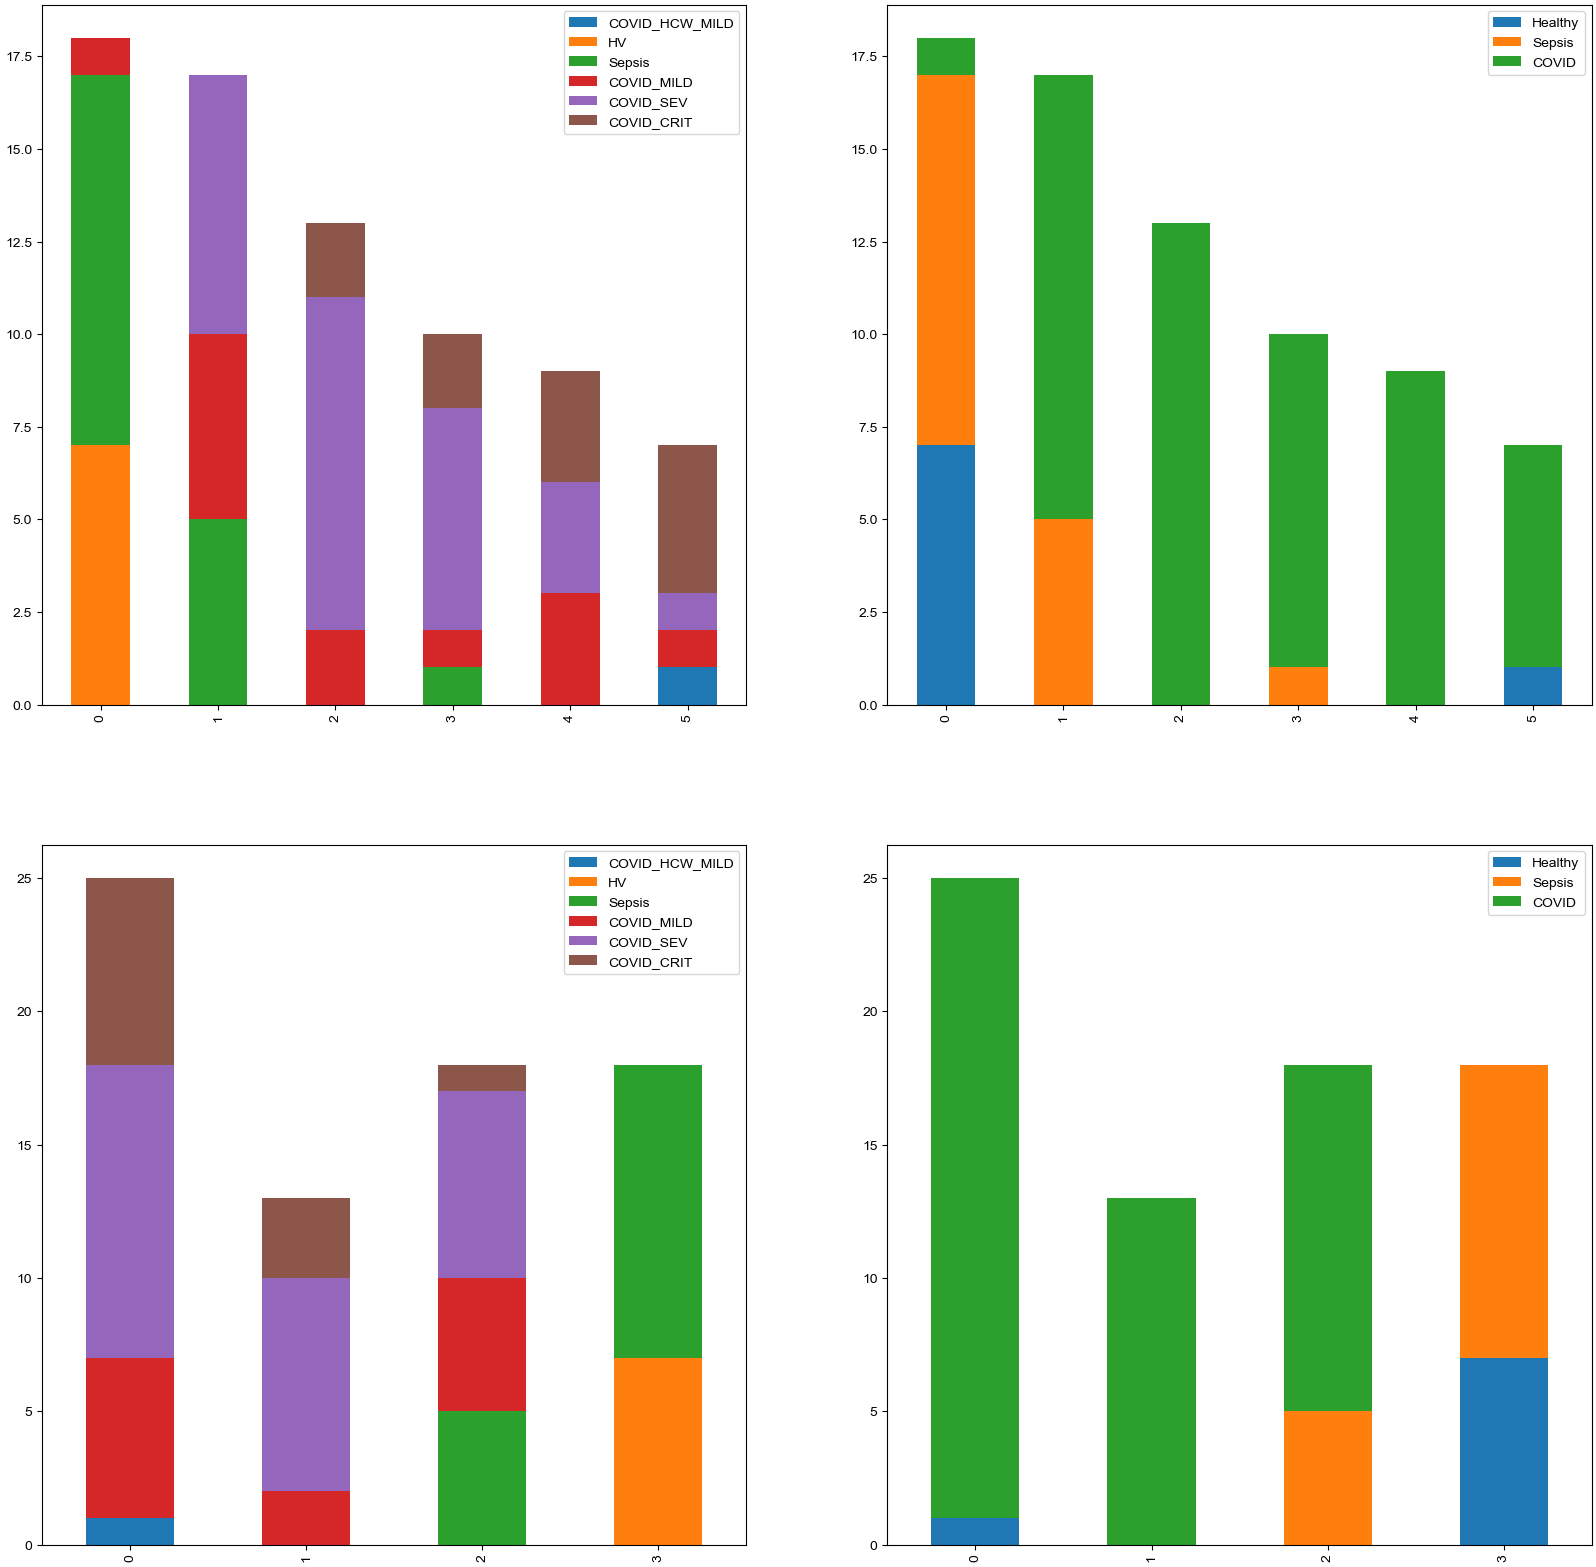

In [13]:
spectral_and_leiden_clustering(snf_ad, 4,1)

In [29]:

connectivities = np.array((sparse.csr_matrix.todense(snf_ad.obsp["connectivities"])), dtype = "float64")


In [30]:
knn_graph_ad = ad.AnnData(connectivities)

/var/folders/d6/19fjtfkn2rb94y09ln9bk6m00000gn/T/ipykernel_37473/3402710125.py:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  knn_graph_ad = ad.AnnData(connectivities)


In [32]:
snf_ad.write_h5ad("snf.h5ad")

In [33]:
snf_ad

AnnData object with n_obs × n_vars = 74 × 74
    obs: 'Disease', 'DiseaseGroup', 'Age', 'Sex', 'Smoking', 'BMI', 'Symptomatic', 'PreExistingHeartDisease', 'PreExistingKidneyDisease', 'PreExistingLungDisease', 'PreExistingDiabetes', 'PreExistingHypertension', 'PreExistingImmunocompromised', 'leiden', 'Sample'
    uns: 'neighbors', 'leiden', 'umap', 'DiseaseGroup_colors', 'Disease_colors'
    obsm: 'X_umap'
    obsp: 'distances', 'connectivities'

In [16]:
snf_ad.obs["Sample"] = snf_ad.obs_names

/opt/anaconda3/envs/thesis/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/anaconda3/envs/thesis/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


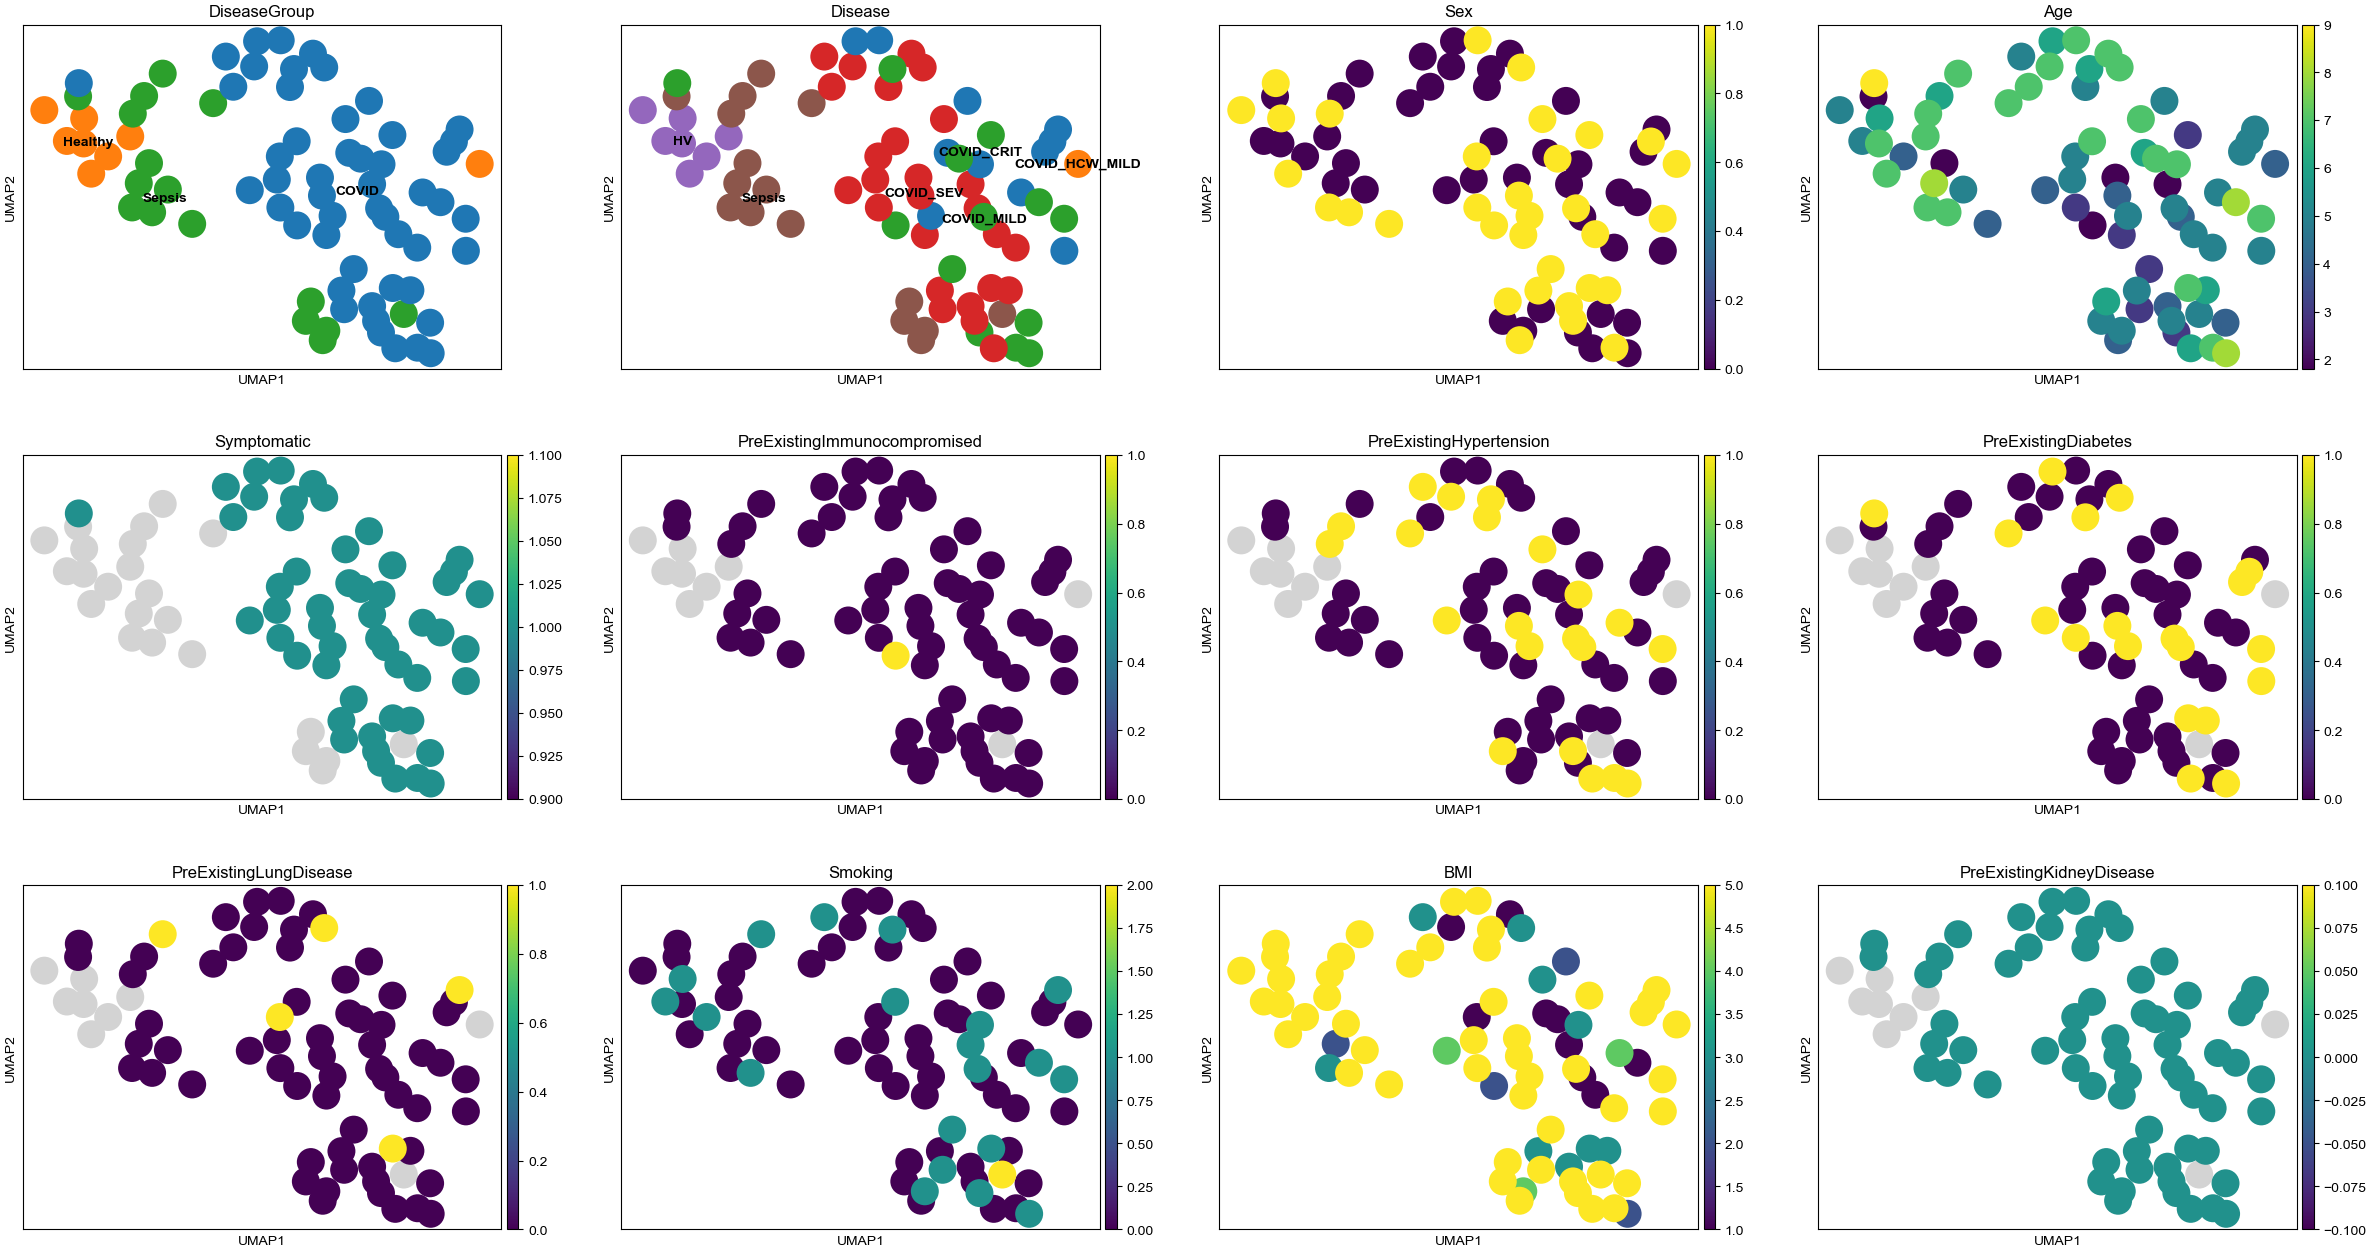

In [17]:
scp.tl.umap(snf_ad)
scp.pl.umap(snf_ad, color=["DiseaseGroup","Disease", "Sex", "Age", "Symptomatic", "PreExistingImmunocompromised", "PreExistingHypertension", "PreExistingDiabetes", "PreExistingLungDisease", "Smoking", "BMI" , "PreExistingKidneyDisease" ], legend_loc="on data")

In [18]:
adata_no_knn = snf_ad.copy()
adata_no_knn.obsp = None
adata_no_knn.uns.pop("neighbors")
adata_no_knn

AnnData object with n_obs × n_vars = 74 × 74
    obs: 'Disease', 'DiseaseGroup', 'Age', 'Sex', 'Smoking', 'BMI', 'Symptomatic', 'PreExistingHeartDisease', 'PreExistingKidneyDisease', 'PreExistingLungDisease', 'PreExistingDiabetes', 'PreExistingHypertension', 'PreExistingImmunocompromised', 'leiden', 'Sample'
    uns: 'leiden', 'umap', 'DiseaseGroup_colors', 'Disease_colors'
    obsm: 'X_umap'

In [24]:
adata_no_knn.write_h5ad("snf.h5ad")

In [23]:
import anndata2ri
from rpy2.robjects import r
anndata2ri.activate()

adata = r('as(some_data, "SingleCellExperiment")')



OSError: cannot load library '/Library/Frameworks/R.framework/Resources/lib/libR.dylib': dlopen(/Library/Frameworks/R.framework/Resources/lib/libR.dylib, 0x0002): tried: '/Library/Frameworks/R.framework/Resources/lib/libR.dylib' (mach-o file, but is an incompatible architecture (have 'arm64', need 'x86_64')), '/System/Volumes/Preboot/Cryptexes/OS/Library/Frameworks/R.framework/Resources/lib/libR.dylib' (no such file), '/Library/Frameworks/R.framework/Resources/lib/libR.dylib' (mach-o file, but is an incompatible architecture (have 'arm64', need 'x86_64')), '/Library/Frameworks/R.framework/Versions/4.3-arm64/Resources/lib/libR.dylib' (mach-o file, but is an incompatible architecture (have 'arm64', need 'x86_64')), '/System/Volumes/Preboot/Cryptexes/OS/Library/Frameworks/R.framework/Versions/4.3-arm64/Resources/lib/libR.dylib' (no such file), '/Library/Frameworks/R.framework/Versions/4.3-arm64/Resources/lib/libR.dylib' (mach-o file, but is an incompatible architecture (have 'arm64', need 'x86_64'))

In [ ]:
import milopy
import milopy.core as milo

OSError: cannot load library '/Library/Frameworks/R.framework/Resources/lib/libR.dylib': dlopen(/Library/Frameworks/R.framework/Resources/lib/libR.dylib, 0x0002): tried: '/Library/Frameworks/R.framework/Resources/lib/libR.dylib' (mach-o file, but is an incompatible architecture (have 'arm64', need 'x86_64')), '/System/Volumes/Preboot/Cryptexes/OS/Library/Frameworks/R.framework/Resources/lib/libR.dylib' (no such file), '/Library/Frameworks/R.framework/Resources/lib/libR.dylib' (mach-o file, but is an incompatible architecture (have 'arm64', need 'x86_64')), '/Library/Frameworks/R.framework/Versions/4.3-arm64/Resources/lib/libR.dylib' (mach-o file, but is an incompatible architecture (have 'arm64', need 'x86_64')), '/System/Volumes/Preboot/Cryptexes/OS/Library/Frameworks/R.framework/Versions/4.3-arm64/Resources/lib/libR.dylib' (no such file), '/Library/Frameworks/R.framework/Versions/4.3-arm64/Resources/lib/libR.dylib' (mach-o file, but is an incompatible architecture (have 'arm64', need 'x86_64'))

In [ ]:
milo = pt.tl.Milo()
mdata = milo.load(snf_ad)

## Tests

In [ ]:
def sample(num_iter):
    adjusted_weights = {}

    score_avg = {}
    dg_score_avg = {}
    d_score_avg = {}
    fused_graphs_avg = {}

    #score_snf = {}
    #dg_score_snf = {}
    #d_score_snf = {}
    #fused_graphs_snf = {}

    for iteration in range(num_iter):
        weights = {}
        random_weights_citeRNA = np.random.uniform(low=0, high=1, size=209)
        random_weights_rest = np.random.uniform(low=2, high=6, size=37)
        i_citeRNA = 0
        i_rest = 0
        for id in graphs_with_74_nodes_dict.keys():
            name = id_to_name[id].split("_")[0]
            if name == "citeRNA":
                weights[id] = random_weights_citeRNA[i_citeRNA]
                i_citeRNA+=1
            else:
                weights[id] = random_weights_rest[i_rest]
                i_rest+=1

        
        #adjusted_weights[iteration] = adjust_weights(weights)
        adjusted_weights[iteration]  = weights

        fused_network_avg = fusion_avg(weights)
        transition_matrix = make_transition_matrix(fused_network_avg.X)
        d_s, dg_s, s = random_walker_objective(transition_matrix)
    
        fused_graphs_avg[iteration] = fused_network_avg
        score_avg[iteration] = s
        dg_score_avg[iteration] = dg_s
        d_score_avg[iteration] = d_s
    

        #fused_network_snf = fusion_snf(weights, 4)
        #transition_matrix = make_transition_matrix(fused_network_snf.X)
        #d_s, dg_s, s = random_walker_objective(transition_matrix)
    
        #fused_graphs_snf[iteration] = fused_network_snf
        #score_snf[iteration] = s
        #dg_score_snf[iteration] = dg_s
        #d_score_snf[iteration] = d_s

    score_avg = {k: v for k, v in sorted(score_avg.items(), key=lambda item: item[1])} # sort according to scores
    best_iteration_avg = list(score_avg.keys())[-1]
    best_weights_avg = adjusted_weights[best_iteration_avg]
    best_fused_graph_avg = fused_graphs_avg[best_iteration_avg]
    best_score_avg = score_avg[best_iteration_avg]

    return best_score_avg, best_weights_avg, best_fused_graph_avg

In [ ]:
x = {id: np.array(sparse.csr_matrix.todense(g.obsp["connectivities"])) for id, g in graphs_with_74_nodes_dict.items()}
x ={id: (data- data.min())/ (data.max() - data.min()) for id, data in x.items()}

In [ ]:
fused_network_snf= compute.snf(list(x.values()), K=4)
fused_network_snf = ad.AnnData(fused_network_snf)
fused_network_snf.obs = graphs_with_74_nodes_dict["G0"].obs


/var/folders/d6/19fjtfkn2rb94y09ln9bk6m00000gn/T/ipykernel_1184/891691830.py:2: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  fused_network_snf = ad.AnnData(fused_network_snf)


interesting patients:  S00005    COVID_SEV   spectral:  0 ,  leiden:  3
interesting patients:  S00020    COVID_CRIT   spectral:  1 ,  leiden:  2
interesting patients:  S00027    COVID_CRIT   spectral:  0 ,  leiden:  3
interesting patients:  S00033    COVID_SEV   spectral:  0 ,  leiden:  3
interesting patients:  S00040    COVID_CRIT   spectral:  0 ,  leiden:  3
interesting patients:  S00065    COVID_CRIT   spectral:  1 ,  leiden:  5
interesting patients:  S00068    COVID_CRIT   spectral:  1 ,  leiden:  2
interesting patients:  S00095    COVID_CRIT   spectral:  1 ,  leiden:  5
interesting patients:  S00119    COVID_SEV   spectral:  0 ,  leiden:  3
patients grouped with healthy leiden  ['H00053', 'H00054', 'H00058', 'H00064', 'H00070', 'H00072', 'H00085', 'N00006', 'N00007', 'N00021', 'N00023', 'N00024', 'N00029', 'N00033', 'S00006']
patients grouped with healthy spectral  [] 



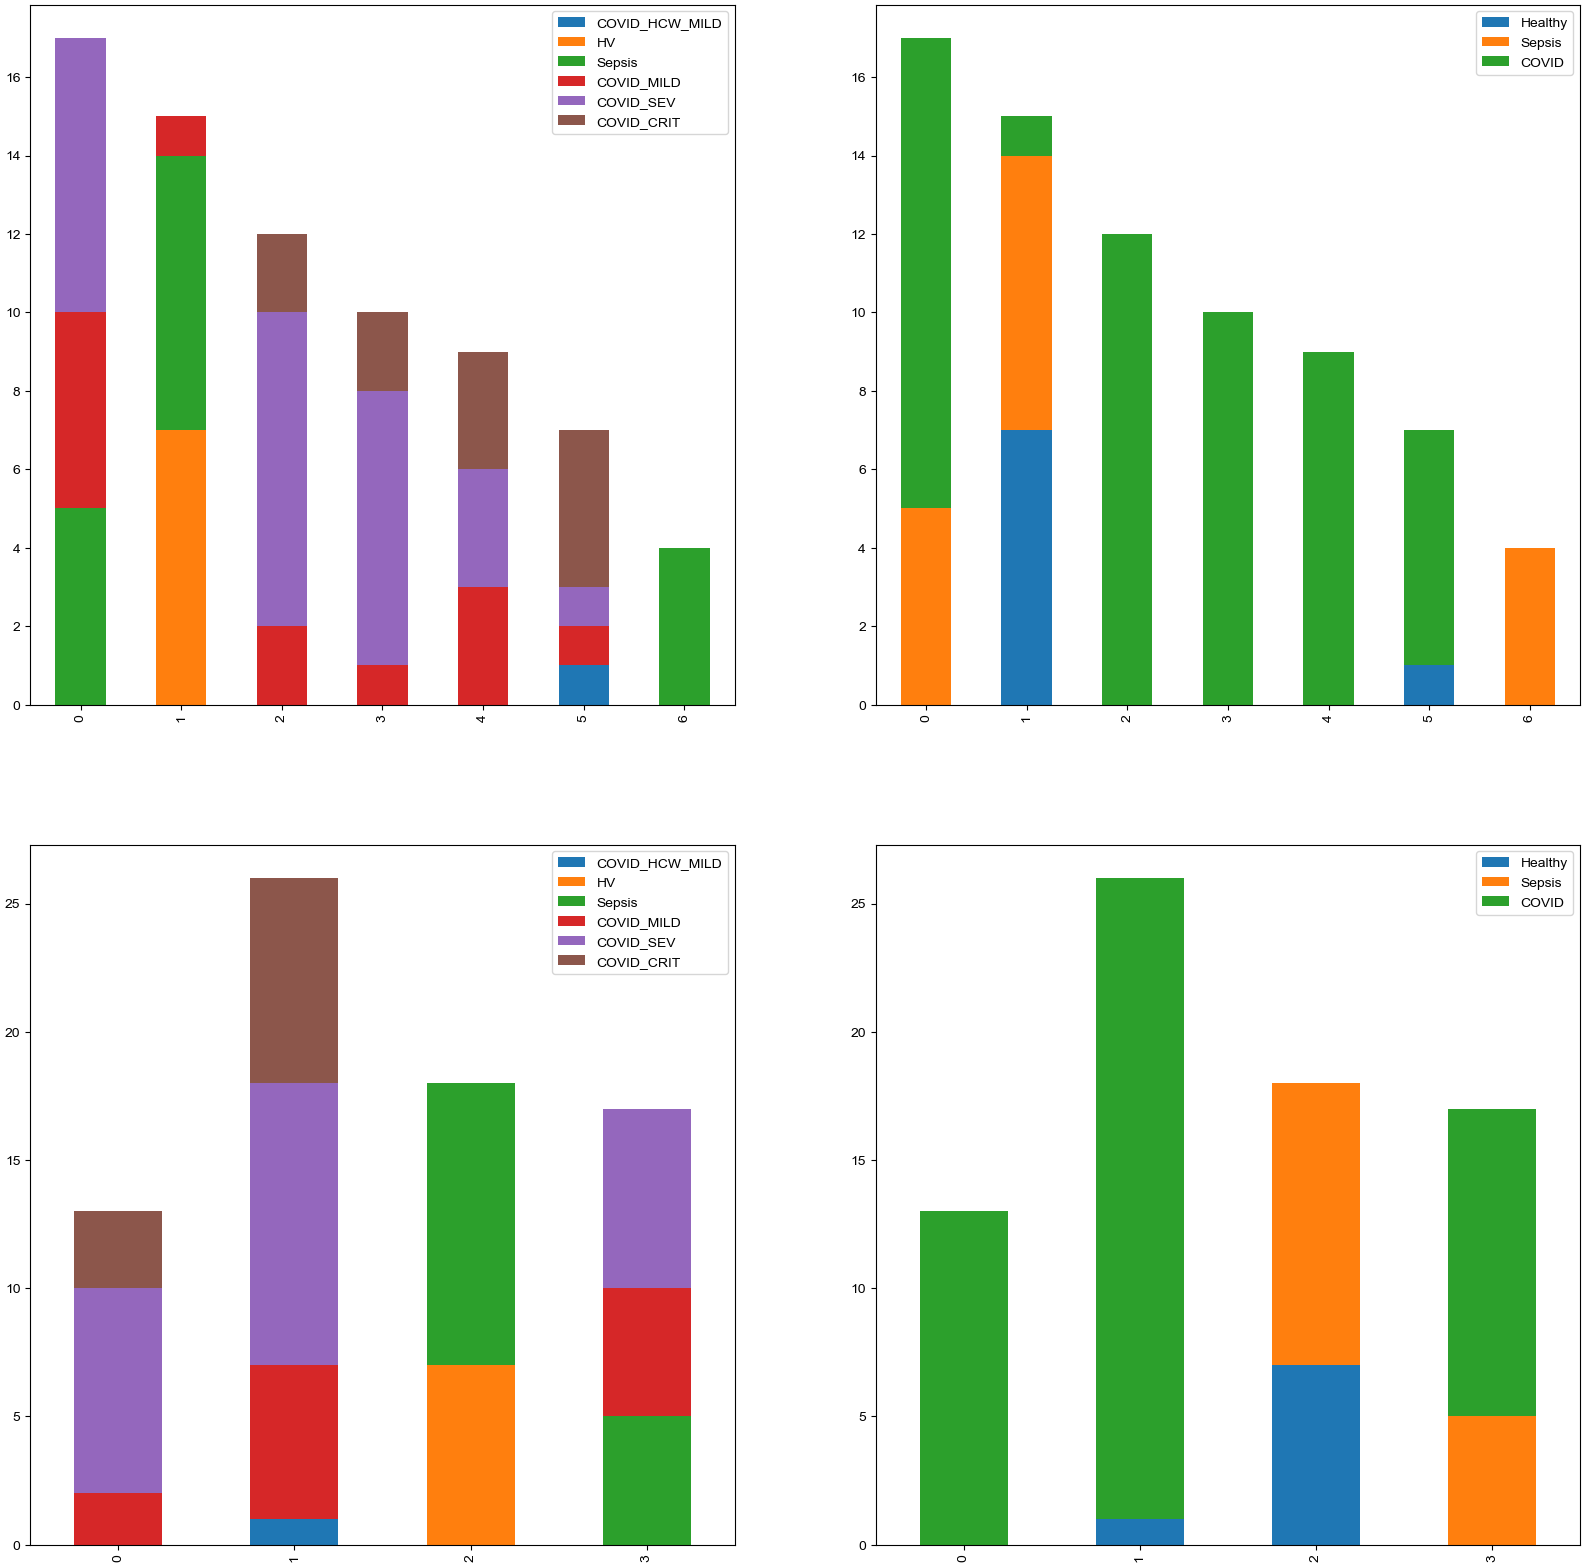

In [ ]:
spectral_and_leiden_clustering(fused_network_snf, 5, 1)

In [ ]:
x = {id: snf_optimize(num_iter= 100, data={id:g.X})[2] for id, g in graphs_with_74_nodes_dict.items()}

/var/folders/d6/19fjtfkn2rb94y09ln9bk6m00000gn/T/ipykernel_1184/1408936411.py:22: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  fused_network_ad = ad.AnnData(fused_network)
/var/folders/d6/19fjtfkn2rb94y09ln9bk6m00000gn/T/ipykernel_1184/1408936411.py:22: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  fused_network_ad = ad.AnnData(fused_network)
/var/folders/d6/19fjtfkn2rb94y09ln9bk6m00000gn/T/ipykernel_1184/1408936411.py:22: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to

KeyboardInterrupt: 

In [ ]:
x ={id: (data.X - data.X.min())/ (data.X.max() - data.X.min()) for id, data in x.items()}
s_fused, w_fused, fused_weighted_avg = weighted_avg_optimize(30000, x)

AttributeError: 'numpy.ndarray' object has no attribute 'X'

In [ ]:
spectral_and_leiden_clustering(fused_weighted_avg, 5, 1)

NameError: name 'fused_weighted_avg' is not defined

### Weighted Avg - Weighted Avg

In [ ]:
K = {"vis": 5 }

data_citeRNA = {id: np.array((sparse.csr_matrix.todense(g.obsp["connectivities"] ))) for id, g in citeRNA_g_with_74.items()}
data_bulkRNA = {id: np.array((sparse.csr_matrix.todense(g.obsp["connectivities"] ))) for id, g in bulkRNA_g_with_74.items()}
data_adt = {id: np.array((sparse.csr_matrix.todense(g.obsp["connectivities"] ))) for id, g in adt_g_with_74.items()}
data_luminex = {id: np.array((sparse.csr_matrix.todense(g.obsp["connectivities"] ))) for id, g in luminex_g_with_74.items()}
data_cytof = {id: np.array((sparse.csr_matrix.todense(g.obsp["connectivities"] ))) for id, g in cytof_g_with_74.items()}
data_facs = {id: np.array((sparse.csr_matrix.todense(g.obsp["connectivities"] ))) for id, g in facs_g_with_74.items()}

s1, w1, g1 = weighted_avg_optimize(10000, data_citeRNA)
s2, w2, g2 = weighted_avg_optimize(10000, data_bulkRNA)
s3, w3, g3 = weighted_avg_optimize(10000, data_adt)
g4 = list(data_luminex.values())[0]
s5, w5, g5 = weighted_avg_optimize(100000, data_cytof)
g6 = list(data_facs.values())[0]

data = {"g1": g1.X, "g2": g2.X, "g3": g3.X, "g4": g4, "g5": g5.X, "g6": g6}
s_fused, w_fused, fused_weighted_avg = weighted_avg_optimize(30000, data)

/opt/anaconda3/envs/thesis/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:248: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)


interesting patients:  S00005    COVID_SEV   spectral:  2 ,  leiden:  0
interesting patients:  S00020    COVID_CRIT   spectral:  0 ,  leiden:  5
interesting patients:  S00027    COVID_CRIT   spectral:  0 ,  leiden:  1
interesting patients:  S00033    COVID_SEV   spectral:  0 ,  leiden:  1
interesting patients:  S00040    COVID_CRIT   spectral:  0 ,  leiden:  1
interesting patients:  S00065    COVID_CRIT   spectral:  0 ,  leiden:  1
interesting patients:  S00068    COVID_CRIT   spectral:  0 ,  leiden:  1
interesting patients:  S00095    COVID_CRIT   spectral:  0 ,  leiden:  1
interesting patients:  S00119    COVID_SEV   spectral:  0 ,  leiden:  1
patients grouped with healthy leiden  ['G05073', 'H00053', 'H00054', 'H00058', 'H00064', 'H00070', 'H00072', 'H00085', 'S00006', 'S00076', 'S00106', 'S00114']
patients grouped with healthy spectral  [] 



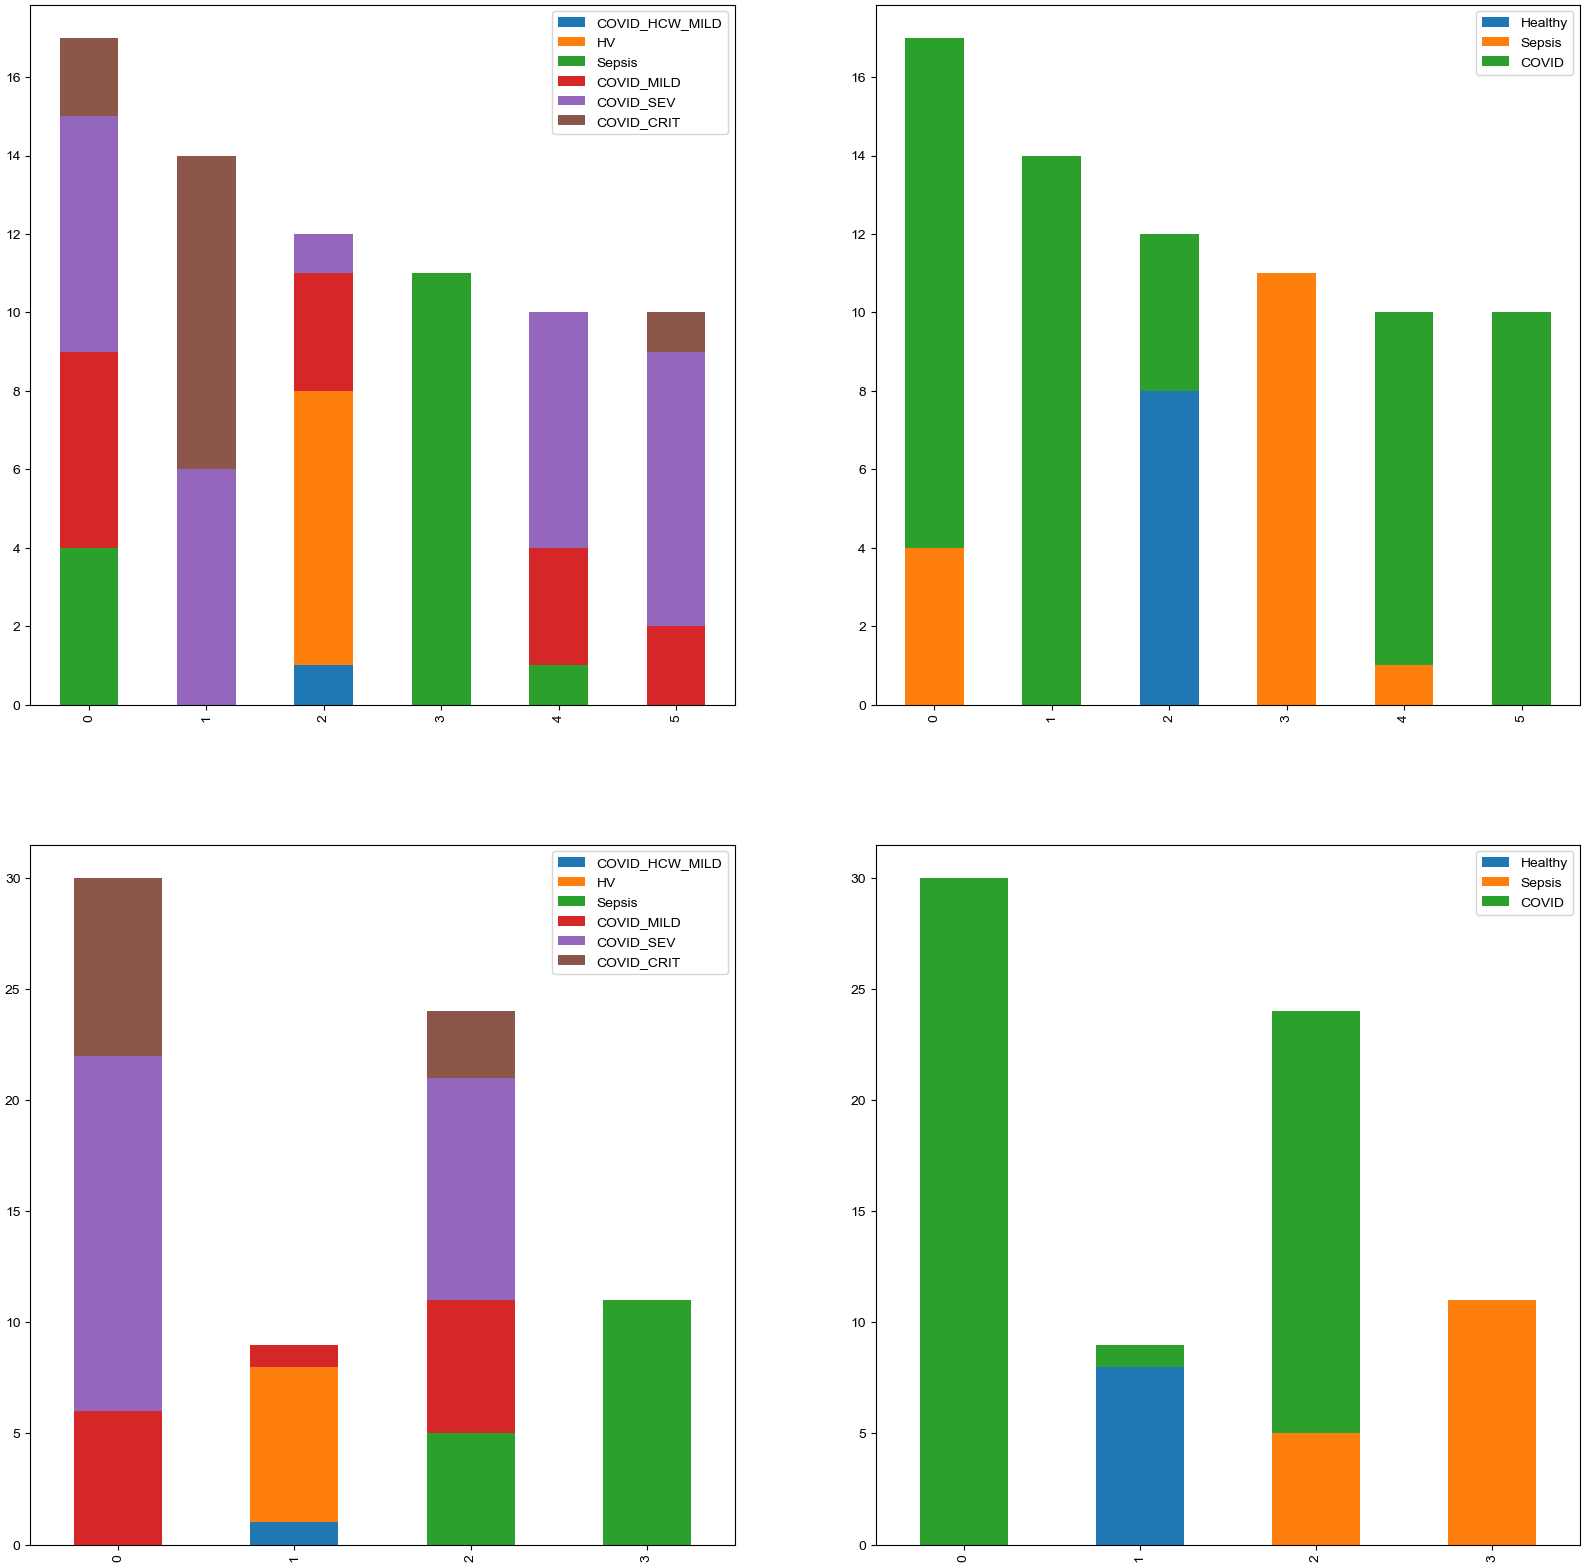

In [ ]:
spectral_and_leiden_clustering(fused_weighted_avg, K["vis"], 1)

### Weighted Avg - SNF

In [ ]:
data_citeRNA = {id: np.array((sparse.csr_matrix.todense(g.obsp["connectivities"] ))) for id, g in citeRNA_g_with_74.items()}
data_bulkRNA = {id: np.array((sparse.csr_matrix.todense(g.obsp["connectivities"] ))) for id, g in bulkRNA_g_with_74.items()}
data_adt = {id: np.array((sparse.csr_matrix.todense(g.obsp["connectivities"] )))  for id, g in adt_g_with_74.items()}
data_luminex = {id: np.array((sparse.csr_matrix.todense(g.obsp["connectivities"] ))) for id, g in luminex_g_with_74.items()}
#data_luminex = {id: g.X for id, g in luminex_g_with_74.items()}
data_cytof = {id: np.array((sparse.csr_matrix.todense(g.obsp["connectivities"] ))) for id, g in cytof_g_with_74.items()}
data_facs = {id: np.array((sparse.csr_matrix.todense(g.obsp["connectivities"] ))) for id, g in facs_g_with_74.items()}
#data_facs = {id: g.X for id, g in facs_g_with_74.items()}

s1, w1, g1 = weighted_avg_optimize(1000, data_citeRNA)
s2, w2, g2 = weighted_avg_optimize(1000, data_bulkRNA)
s3, w3, g3 = weighted_avg_optimize(1000, data_adt)
g4 = list(data_luminex.values())[0]
s5, w5, g5 = weighted_avg_optimize(10000, data_cytof)
g6 = list(data_facs.values())[0]

data = {"g1": g1.X, "g2": g2.X, "g3": g3.X, "g4": g4, "g5": g5.X, "g6": g6}

/var/folders/d6/19fjtfkn2rb94y09ln9bk6m00000gn/T/ipykernel_76409/4013246925.py:19: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  fused_network_ad = ad.AnnData(fused_network)
/var/folders/d6/19fjtfkn2rb94y09ln9bk6m00000gn/T/ipykernel_76409/4013246925.py:19: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  fused_network_ad = ad.AnnData(fused_network)
/var/folders/d6/19fjtfkn2rb94y09ln9bk6m00000gn/T/ipykernel_76409/4013246925.py:19: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly

interesting patients:  S00005    COVID_SEV   spectral:  1 ,  leiden:  1
interesting patients:  S00020    COVID_CRIT   spectral:  0 ,  leiden:  0
interesting patients:  S00027    COVID_CRIT   spectral:  0 ,  leiden:  3
interesting patients:  S00033    COVID_SEV   spectral:  0 ,  leiden:  0
interesting patients:  S00040    COVID_CRIT   spectral:  3 ,  leiden:  0
interesting patients:  S00065    COVID_CRIT   spectral:  0 ,  leiden:  0
interesting patients:  S00068    COVID_CRIT   spectral:  0 ,  leiden:  0
interesting patients:  S00095    COVID_CRIT   spectral:  0 ,  leiden:  0
interesting patients:  S00119    COVID_SEV   spectral:  0 ,  leiden:  0
patients grouped with healthy leiden  ['G05073', 'H00053', 'H00054', 'H00058', 'H00064', 'H00070', 'H00072', 'H00085', 'N00007', 'N00012', 'N00017', 'N00023', 'N00028', 'N00033', 'N00038', 'N00039', 'N00047', 'S00002', 'S00006', 'S00007', 'S00016', 'S00020', 'S00024', 'S00027', 'S00033', 'S00037', 'S00039', 'S00040', 'S00041', 'S00042', 'S00045

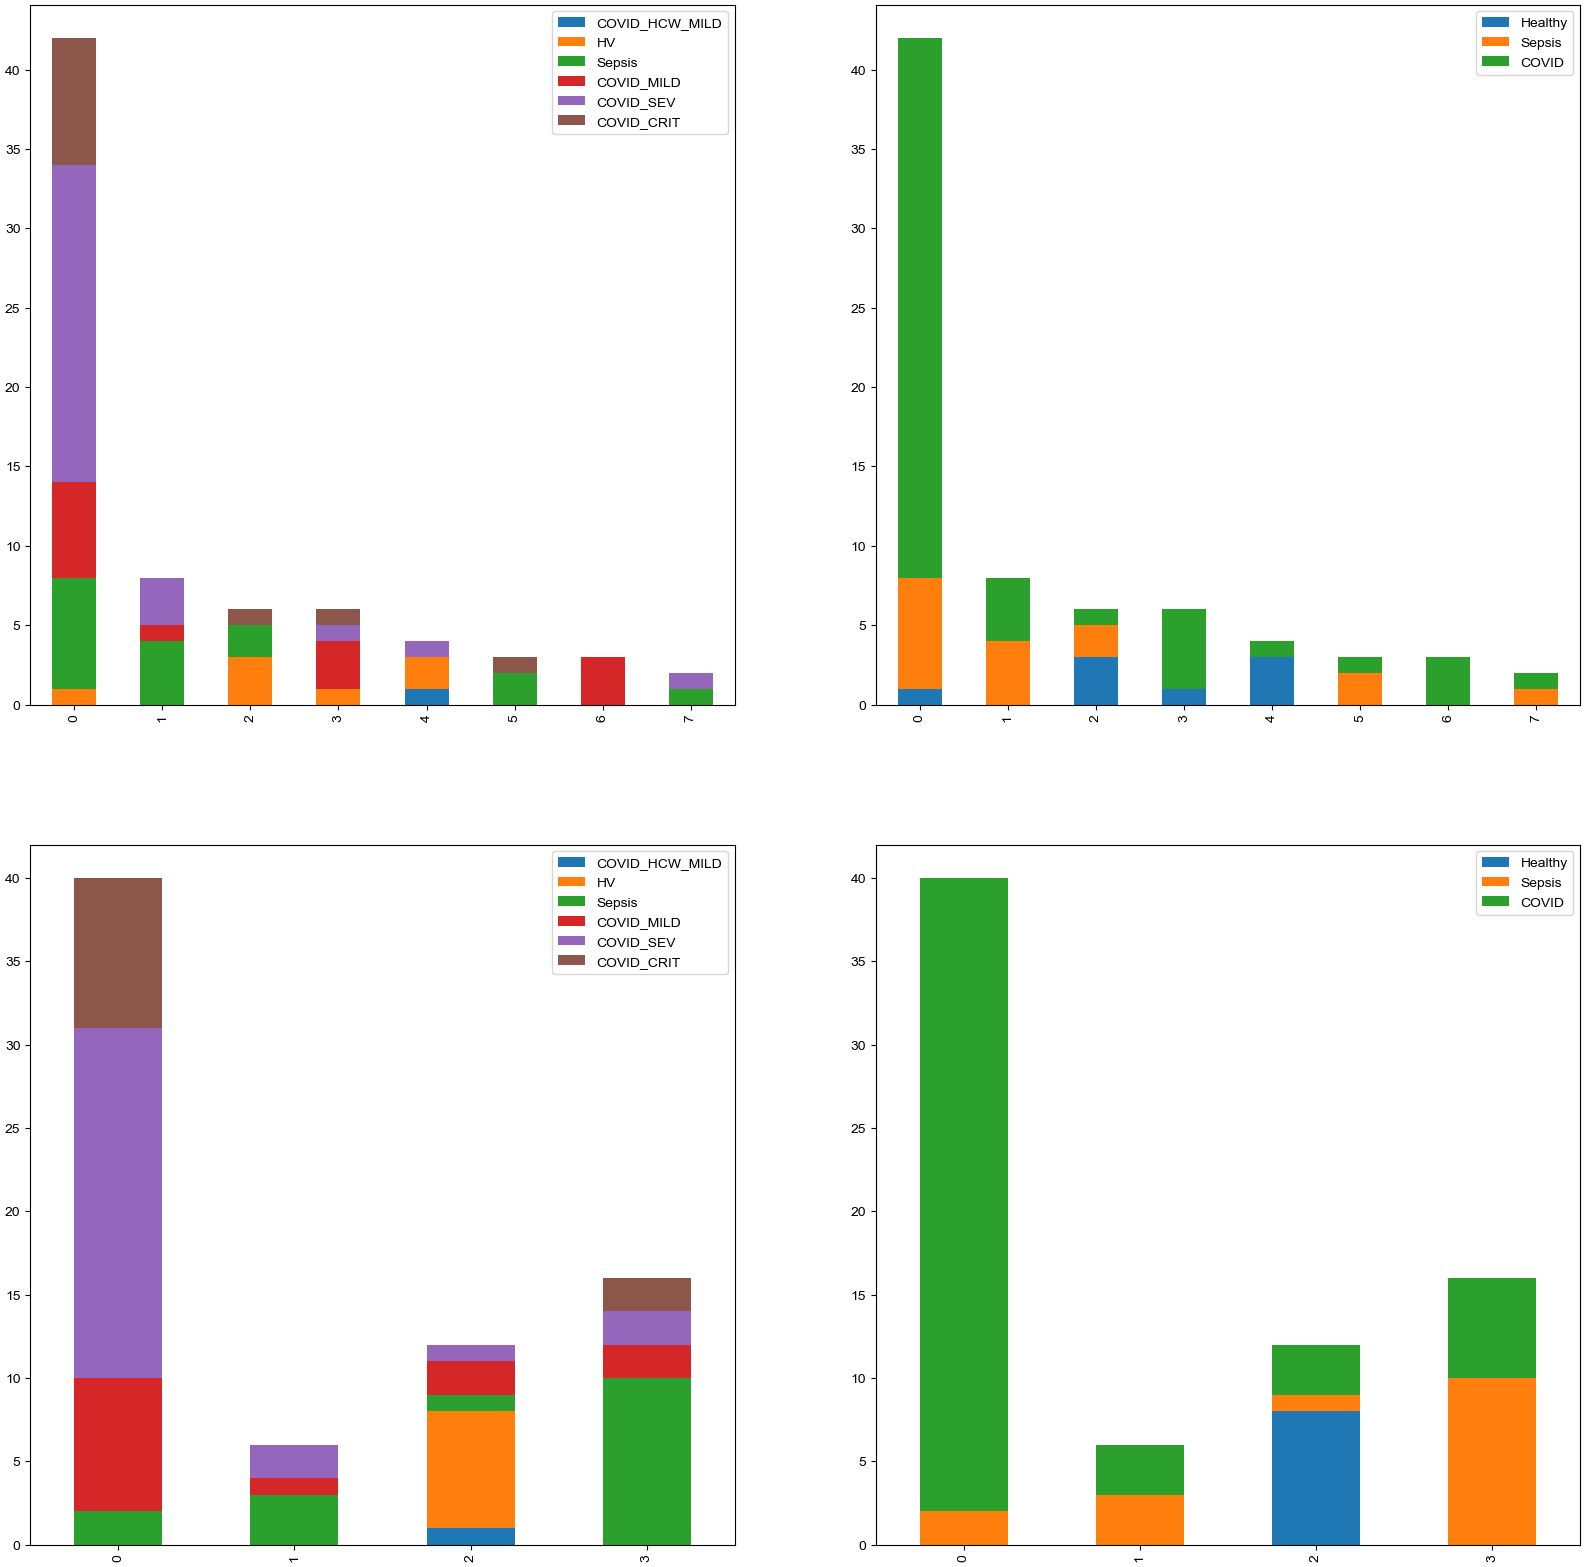

In [ ]:
K = {"second_f": 5, "vis": 5 }

hp, s, fused_snf = snf_optimize(data=data, num_iter=300)

spectral_and_leiden_clustering(fused_snf, K["vis"], 1)

In [ ]:
data_citeRNA = {id: np.array((sparse.csr_matrix.todense(g.obsp["connectivities"] ))) for id, g in citeRNA_g_with_74.items()}
data_bulkRNA = {id: np.array((sparse.csr_matrix.todense(g.obsp["connectivities"] ))) for id, g in bulkRNA_g_with_74.items()}
data_adt = {id: np.array((sparse.csr_matrix.todense(g.obsp["connectivities"] )))  for id, g in adt_g_with_74.items()}
#data_luminex = {id: np.array((sparse.csr_matrix.todense(g.obsp["connectivities"] ))) for id, g in luminex_g_with_74.items()}
data_luminex = {id: g.X for id, g in luminex_g_with_74.items()}
data_cytof = {id: np.array((sparse.csr_matrix.todense(g.obsp["connectivities"] ))) for id, g in cytof_g_with_74.items()}
#data_facs = {id: np.array((sparse.csr_matrix.todense(g.obsp["connectivities"] ))) for id, g in facs_g_with_74.items()}
data_facs = {id: g.X for id, g in facs_g_with_74.items()}

s1, w1, g1 = weighted_avg_optimize(1000, data_citeRNA)
s2, w2, g2 = weighted_avg_optimize(1000, data_bulkRNA)
s3, w3, g3 = weighted_avg_optimize(1000, data_adt)
g4 = list(data_luminex.values())[0]
s5, w5, g5 = weighted_avg_optimize(10000, data_cytof)
g6 = list(data_facs.values())[0]

data = {"g1": g1.X, "g2": g2.X, "g3": g3.X, "g4": g4, "g5": g5.X, "g6": g6}

/var/folders/d6/19fjtfkn2rb94y09ln9bk6m00000gn/T/ipykernel_76409/4013246925.py:19: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  fused_network_ad = ad.AnnData(fused_network)
/var/folders/d6/19fjtfkn2rb94y09ln9bk6m00000gn/T/ipykernel_76409/4013246925.py:19: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  fused_network_ad = ad.AnnData(fused_network)
/var/folders/d6/19fjtfkn2rb94y09ln9bk6m00000gn/T/ipykernel_76409/4013246925.py:19: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly

interesting patients:  S00005    COVID_SEV   spectral:  0 ,  leiden:  0
interesting patients:  S00020    COVID_CRIT   spectral:  0 ,  leiden:  3
interesting patients:  S00027    COVID_CRIT   spectral:  0 ,  leiden:  0
interesting patients:  S00033    COVID_SEV   spectral:  0 ,  leiden:  0
interesting patients:  S00040    COVID_CRIT   spectral:  0 ,  leiden:  0
interesting patients:  S00065    COVID_CRIT   spectral:  0 ,  leiden:  0
interesting patients:  S00068    COVID_CRIT   spectral:  0 ,  leiden:  0
interesting patients:  S00095    COVID_CRIT   spectral:  0 ,  leiden:  4
interesting patients:  S00119    COVID_SEV   spectral:  0 ,  leiden:  2
patients grouped with healthy leiden  ['G05073', 'H00053', 'H00054', 'H00058', 'H00064', 'H00070', 'H00072', 'H00085', 'N00006', 'N00007', 'N00012', 'N00017', 'N00021', 'N00023', 'N00024', 'N00028', 'N00029', 'N00032', 'N00033', 'N00037', 'N00038', 'N00039', 'N00047', 'N00050', 'S00005', 'S00006', 'S00007', 'S00024', 'S00027', 'S00033', 'S00040

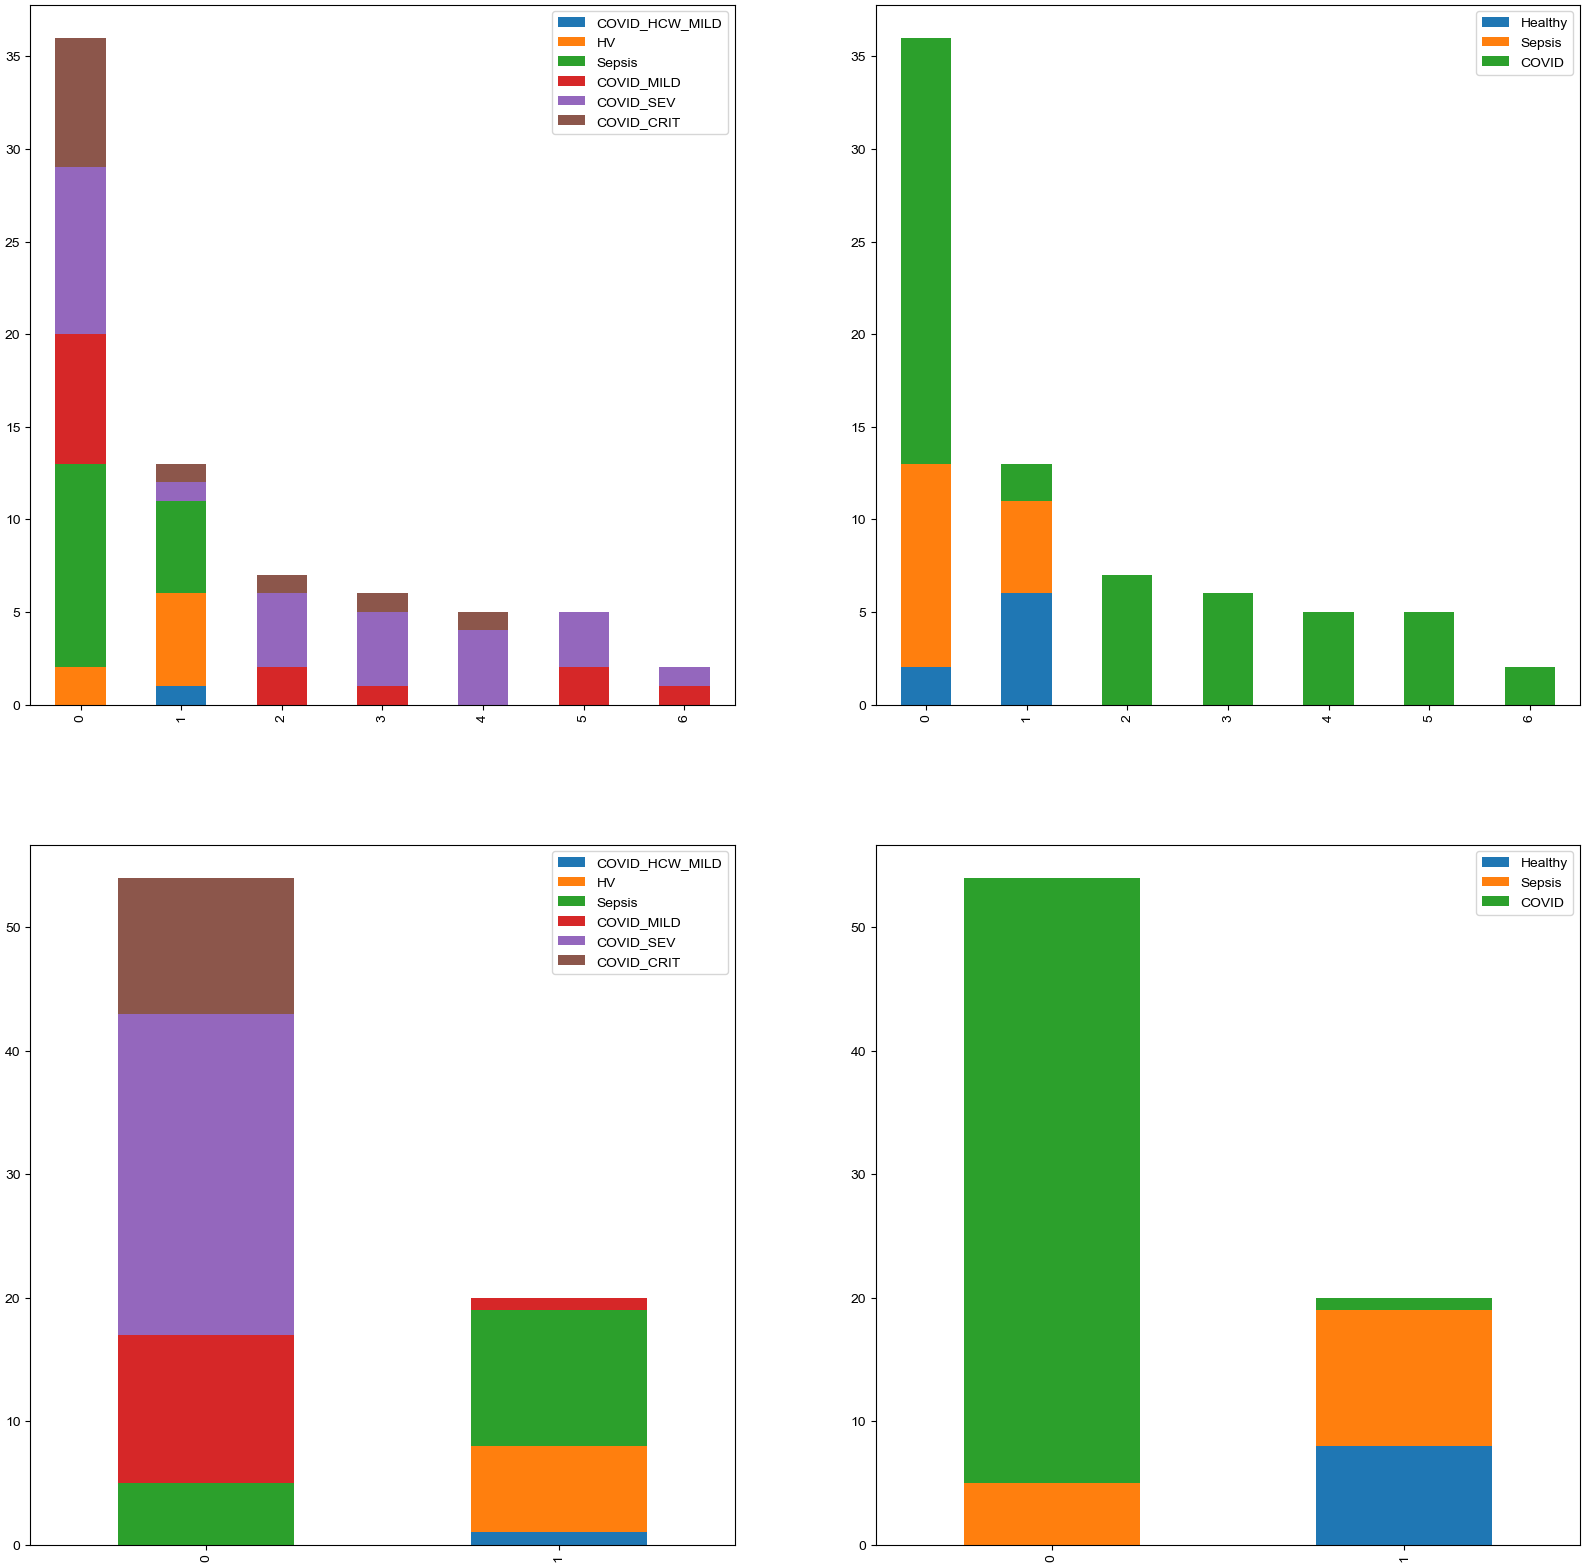

In [ ]:
K = {"second_f": 5, "vis": 5 }

hp, s, fused_snf = snf_optimize(data=data, num_iter=300)

spectral_and_leiden_clustering(fused_snf, K["vis"], 1)

### SNF - Weighted Avg

In [ ]:
K = {"first_f": 7, "vis": 7 }

data_citeRNA = {id: g.X for id, g in citeRNA_g_with_74.items()}
data_bulkRNA = {id: g.X for id, g in bulkRNA_g_with_74.items()}
data_adt = {id: g.X for id, g in adt_g_with_74.items()}
data_luminex = {id: np.array((sparse.csr_matrix.todense(g.obsp["connectivities"] ))) for id, g in luminex_g_with_74.items()}
data_cytof = {id: g.X for id, g in cytof_g_with_74.items()}
data_facs = {id: np.array((sparse.csr_matrix.todense(g.obsp["connectivities"] ))) for id, g in facs_g_with_74.items()}

hp1, s1, g1 = snf_optimize(data=data_citeRNA, num_iter=100)
hp2, s2, g2 = snf_optimize(data=data_bulkRNA, num_iter=100)
hp3, s3, g3 = snf_optimize(data=data_adt, num_iter=100)
g4 = list(data_luminex.values())[0]
hp5, s5, g5 = snf_optimize(data=data_cytof, num_iter=100)
g6 = list(data_facs.values())[0]

/var/folders/d6/19fjtfkn2rb94y09ln9bk6m00000gn/T/ipykernel_76409/4013246925.py:19: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  fused_network_ad = ad.AnnData(fused_network)
/var/folders/d6/19fjtfkn2rb94y09ln9bk6m00000gn/T/ipykernel_76409/4013246925.py:19: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  fused_network_ad = ad.AnnData(fused_network)
/var/folders/d6/19fjtfkn2rb94y09ln9bk6m00000gn/T/ipykernel_76409/4013246925.py:19: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly

/opt/anaconda3/envs/thesis/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:248: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)


interesting patients:  S00005    COVID_SEV   spectral:  0 ,  leiden:  0
interesting patients:  S00020    COVID_CRIT   spectral:  2 ,  leiden:  3
interesting patients:  S00027    COVID_CRIT   spectral:  2 ,  leiden:  0
interesting patients:  S00033    COVID_SEV   spectral:  2 ,  leiden:  1
interesting patients:  S00040    COVID_CRIT   spectral:  2 ,  leiden:  0
interesting patients:  S00065    COVID_CRIT   spectral:  2 ,  leiden:  0
interesting patients:  S00068    COVID_CRIT   spectral:  0 ,  leiden:  0
interesting patients:  S00095    COVID_CRIT   spectral:  2 ,  leiden:  0
interesting patients:  S00119    COVID_SEV   spectral:  2 ,  leiden:  5
patients grouped with healthy leiden  ['G05073', 'H00053', 'H00054', 'H00058', 'H00064', 'H00070', 'H00072', 'H00085', 'S00114']
patients grouped with healthy spectral  [] 



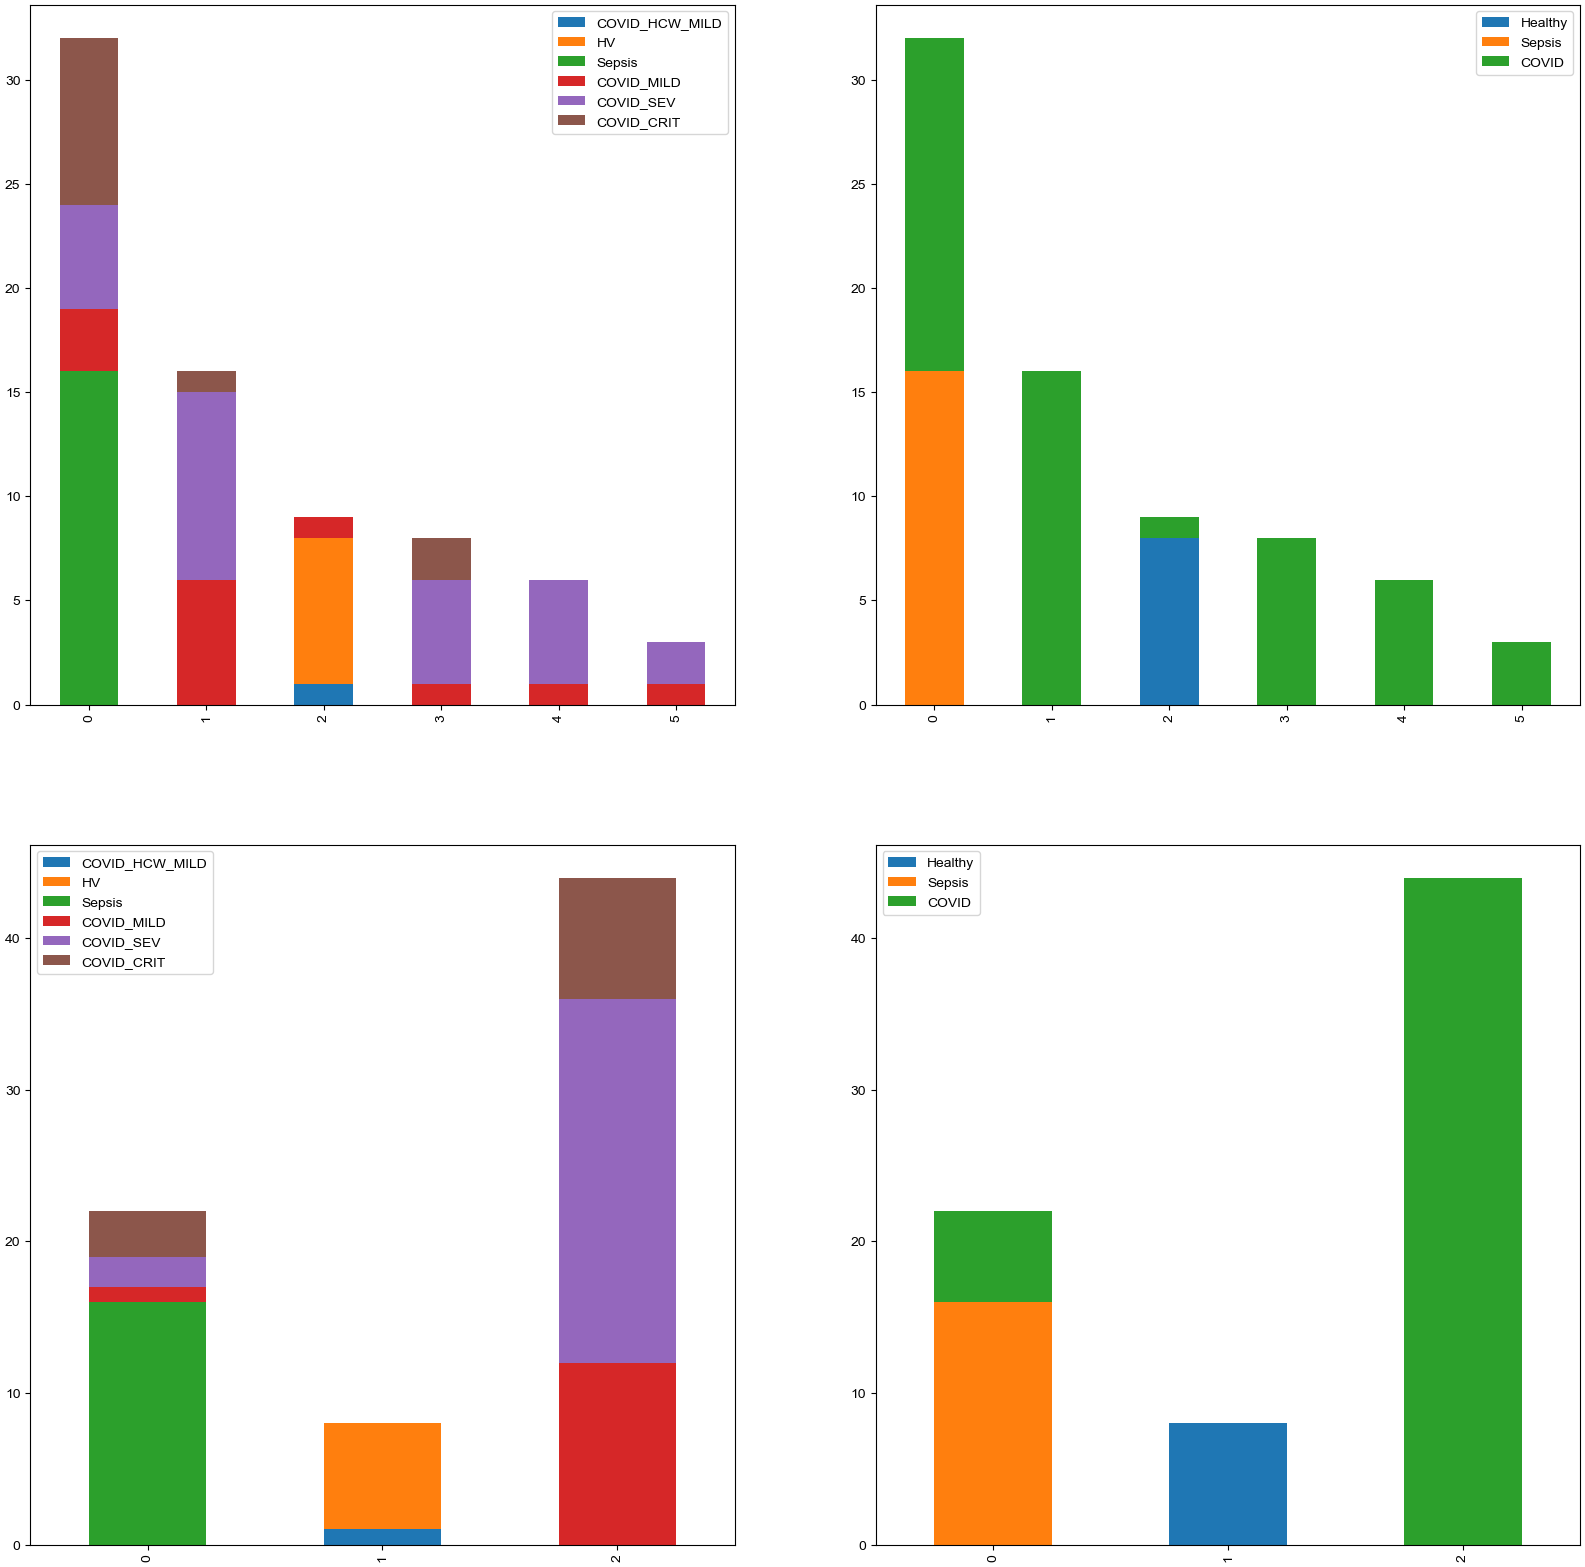

In [ ]:
data = {"g1": g1.X, "g2": g2.X, "g3": g3.X, "g4": g4, "g5": g5.X, "g6": g6}
s, w, fused_weighted_avg = weighted_avg_optimize(100000, data)

spectral_and_leiden_clustering(fused_weighted_avg, K["vis"], 1)

### SNF - SNF

In [ ]:
K = {"first_f": 5, "second_f": 5, "vis": 5 }

data_citeRNA = {id: g.X for id, g in citeRNA_g_with_74.items()}
data_bulkRNA = {id: g.X for id, g in bulkRNA_g_with_74.items()}
data_adt = {id: g.X for id, g in adt_g_with_74.items()}
#data_luminex = {id: np.array((sparse.csr_matrix.todense(g.obsp["connectivities"] ))) for id, g in luminex_g_with_74.items()}
data_luminex = {id: g.X for id, g in luminex_g_with_74.items()}
data_cytof = {id: g.X for id, g in cytof_g_with_74.items()}
#data_facs = {id: np.array((sparse.csr_matrix.todense(g.obsp["connectivities"] ))) for id, g in facs_g_with_74.items()}
data_facs = {id: g.X for id, g in facs_g_with_74.items()}

hp1, s1, g1 = snf_optimize(data=data_citeRNA, num_iter=100)
hp2, s2, g2 = snf_optimize(data=data_bulkRNA, num_iter=100)
hp3, s3, g3 = snf_optimize(data=data_adt, num_iter=100)
g4 = list(data_luminex.values())[0]
hp5, s5, g5 = snf_optimize(data=data_cytof, num_iter=100)
g6 = list(data_facs.values())[0]


/var/folders/d6/19fjtfkn2rb94y09ln9bk6m00000gn/T/ipykernel_76409/4013246925.py:19: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  fused_network_ad = ad.AnnData(fused_network)
/var/folders/d6/19fjtfkn2rb94y09ln9bk6m00000gn/T/ipykernel_76409/4013246925.py:19: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  fused_network_ad = ad.AnnData(fused_network)
/var/folders/d6/19fjtfkn2rb94y09ln9bk6m00000gn/T/ipykernel_76409/4013246925.py:19: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly

/var/folders/d6/19fjtfkn2rb94y09ln9bk6m00000gn/T/ipykernel_76409/4013246925.py:19: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  fused_network_ad = ad.AnnData(fused_network)
/var/folders/d6/19fjtfkn2rb94y09ln9bk6m00000gn/T/ipykernel_76409/4013246925.py:19: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  fused_network_ad = ad.AnnData(fused_network)
/var/folders/d6/19fjtfkn2rb94y09ln9bk6m00000gn/T/ipykernel_76409/4013246925.py:19: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly

interesting patients:  S00005    COVID_SEV   spectral:  0 ,  leiden:  0
interesting patients:  S00020    COVID_CRIT   spectral:  0 ,  leiden:  5
interesting patients:  S00027    COVID_CRIT   spectral:  0 ,  leiden:  0
interesting patients:  S00033    COVID_SEV   spectral:  0 ,  leiden:  0
interesting patients:  S00040    COVID_CRIT   spectral:  0 ,  leiden:  0
interesting patients:  S00065    COVID_CRIT   spectral:  0 ,  leiden:  1
interesting patients:  S00068    COVID_CRIT   spectral:  0 ,  leiden:  2
interesting patients:  S00095    COVID_CRIT   spectral:  0 ,  leiden:  0
interesting patients:  S00119    COVID_SEV   spectral:  0 ,  leiden:  3
patients grouped with healthy leiden  ['G05073', 'H00053', 'H00054', 'H00058', 'H00064', 'H00070', 'H00072', 'H00085', 'N00007', 'N00033', 'N00047', 'S00039', 'S00058', 'S00065', 'S00076', 'S00094', 'S00113', 'S00114']
patients grouped with healthy spectral  [] 



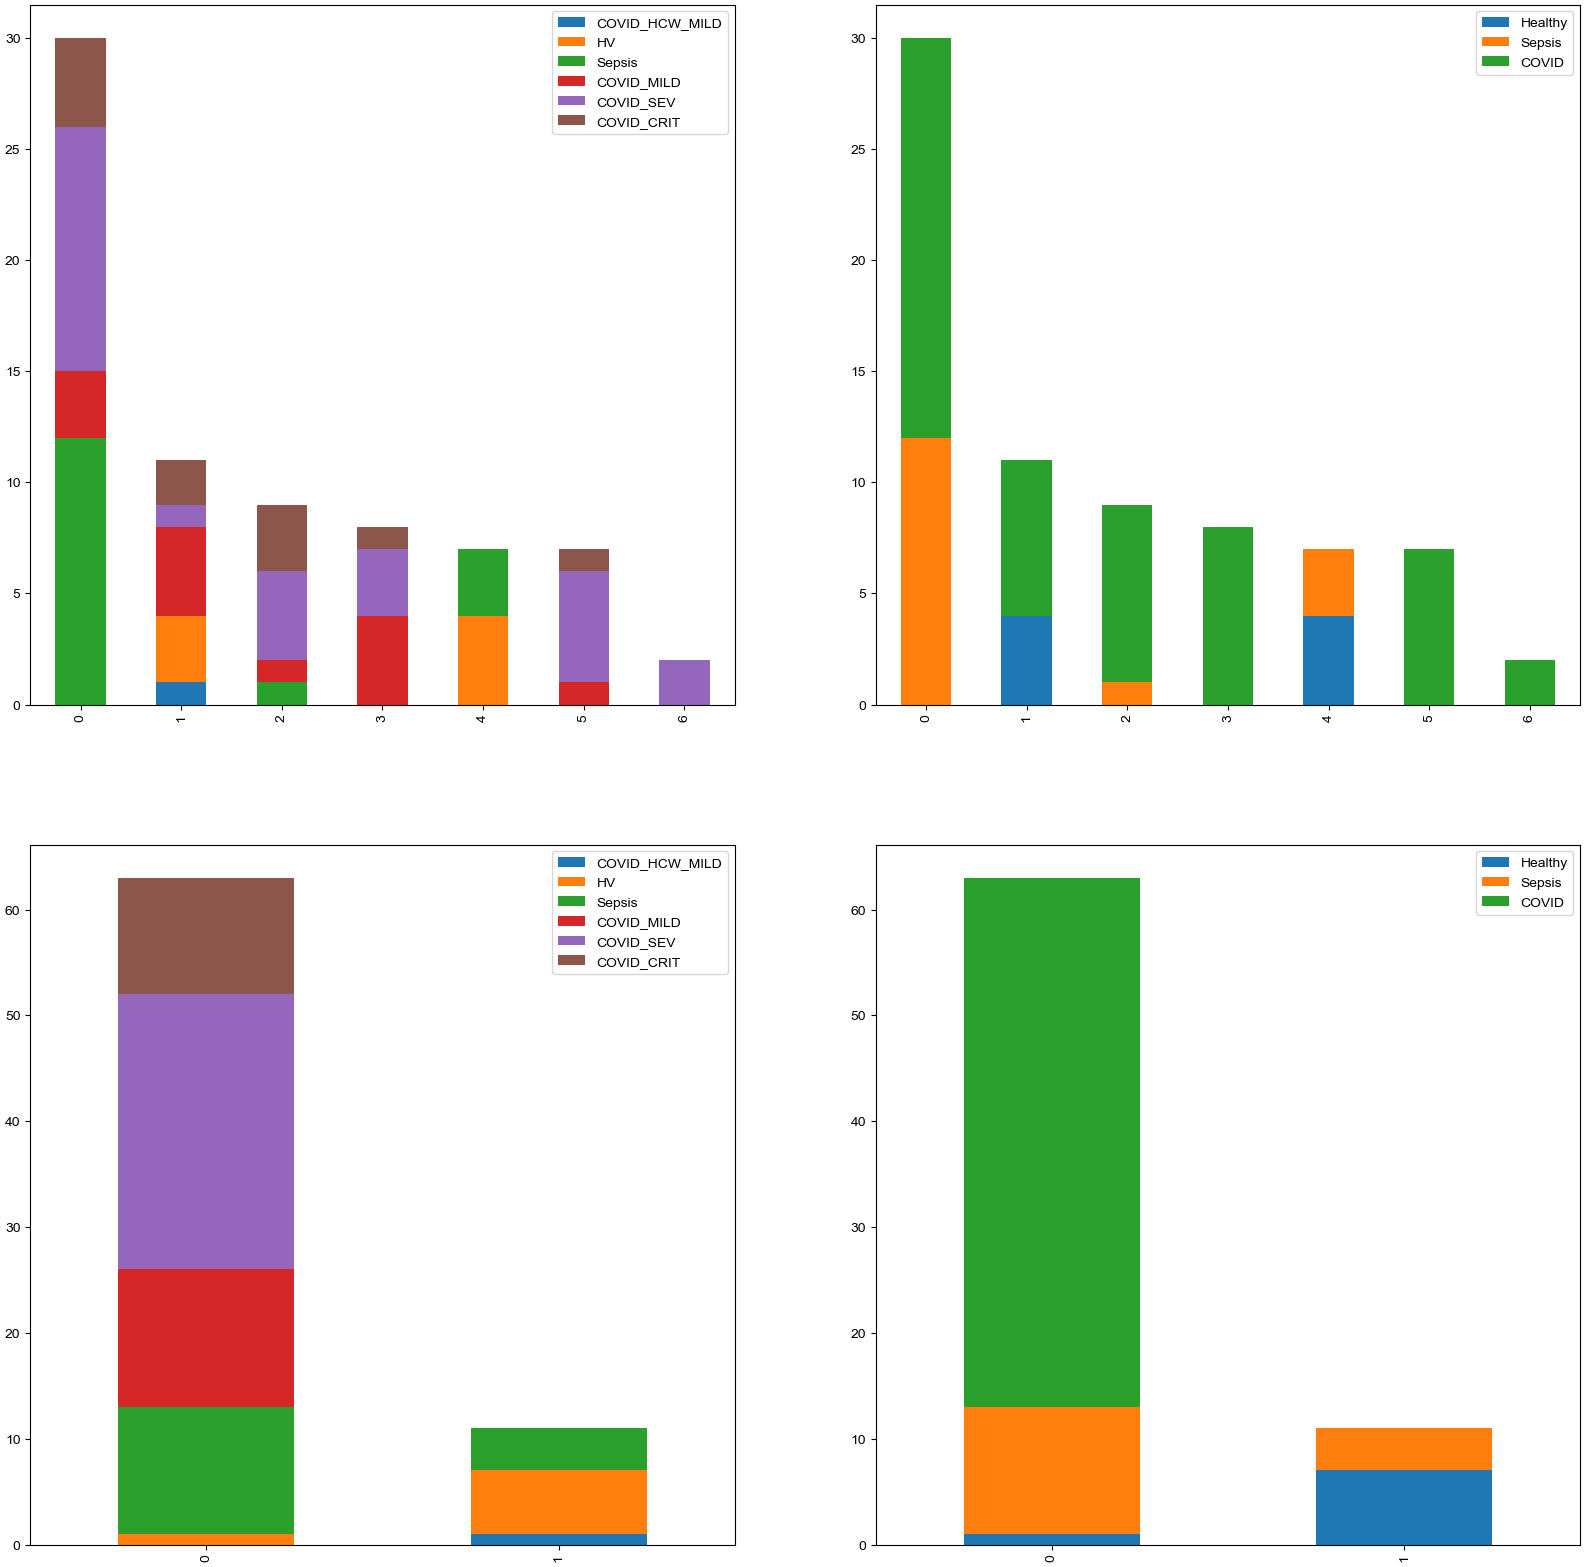

In [ ]:
data = {"g1": g1.X, "g2": g2.X, "g3": g3.X, "g4": g4, "g5": g5.X, "g6": g6}
hp_fused, score_fused, fused_snf = snf_optimize(data = data, num_iter=100)

spectral_and_leiden_clustering(fused_snf, K["vis"], 1)

In [ ]:
K = {"first_f": 5, "second_f": 5, "vis": 5 }

data_citeRNA = {id: g.X for id, g in citeRNA_g_with_74.items()}
data_bulkRNA = {id: g.X for id, g in bulkRNA_g_with_74.items()}
data_adt = {id: g.X for id, g in adt_g_with_74.items()}
data_luminex = {id: np.array((sparse.csr_matrix.todense(g.obsp["connectivities"] ))) for id, g in luminex_g_with_74.items()}
#data_luminex = {id: g.X for id, g in luminex_g_with_74.items()}
data_cytof = {id: g.X for id, g in cytof_g_with_74.items()}
data_facs = {id: np.array((sparse.csr_matrix.todense(g.obsp["connectivities"] ))) for id, g in facs_g_with_74.items()}
#data_facs = {id: g.X for id, g in facs_g_with_74.items()}

hp1, s1, g1 = snf_optimize(data=data_citeRNA, num_iter=100)
hp2, s2, g2 = snf_optimize(data=data_bulkRNA, num_iter=100)
hp3, s3, g3 = snf_optimize(data=data_adt, num_iter=100)
g4 = list(data_luminex.values())[0]
hp5, s5, g5 = snf_optimize(data=data_cytof, num_iter=100)
g6 = list(data_facs.values())[0]


/var/folders/d6/19fjtfkn2rb94y09ln9bk6m00000gn/T/ipykernel_76409/4013246925.py:19: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  fused_network_ad = ad.AnnData(fused_network)
/var/folders/d6/19fjtfkn2rb94y09ln9bk6m00000gn/T/ipykernel_76409/4013246925.py:19: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  fused_network_ad = ad.AnnData(fused_network)
/var/folders/d6/19fjtfkn2rb94y09ln9bk6m00000gn/T/ipykernel_76409/4013246925.py:19: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly

/var/folders/d6/19fjtfkn2rb94y09ln9bk6m00000gn/T/ipykernel_76409/4013246925.py:19: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  fused_network_ad = ad.AnnData(fused_network)
/var/folders/d6/19fjtfkn2rb94y09ln9bk6m00000gn/T/ipykernel_76409/4013246925.py:19: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  fused_network_ad = ad.AnnData(fused_network)
/var/folders/d6/19fjtfkn2rb94y09ln9bk6m00000gn/T/ipykernel_76409/4013246925.py:19: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly

interesting patients:  S00005    COVID_SEV   spectral:  0 ,  leiden:  1
interesting patients:  S00020    COVID_CRIT   spectral:  0 ,  leiden:  0
interesting patients:  S00027    COVID_CRIT   spectral:  2 ,  leiden:  2
interesting patients:  S00033    COVID_SEV   spectral:  0 ,  leiden:  1
interesting patients:  S00040    COVID_CRIT   spectral:  0 ,  leiden:  0
interesting patients:  S00065    COVID_CRIT   spectral:  0 ,  leiden:  3
interesting patients:  S00068    COVID_CRIT   spectral:  0 ,  leiden:  0
interesting patients:  S00095    COVID_CRIT   spectral:  0 ,  leiden:  0
interesting patients:  S00119    COVID_SEV   spectral:  0 ,  leiden:  0
patients grouped with healthy leiden  ['G05073', 'H00053', 'H00054', 'H00058', 'H00064', 'H00070', 'H00072', 'H00085', 'N00007', 'N00012', 'N00017', 'N00021', 'N00024', 'N00028', 'N00029', 'N00033', 'N00037', 'N00038', 'N00039', 'N00047', 'N00050', 'S00006', 'S00007', 'S00016', 'S00020', 'S00024', 'S00027', 'S00037', 'S00039', 'S00040', 'S00041

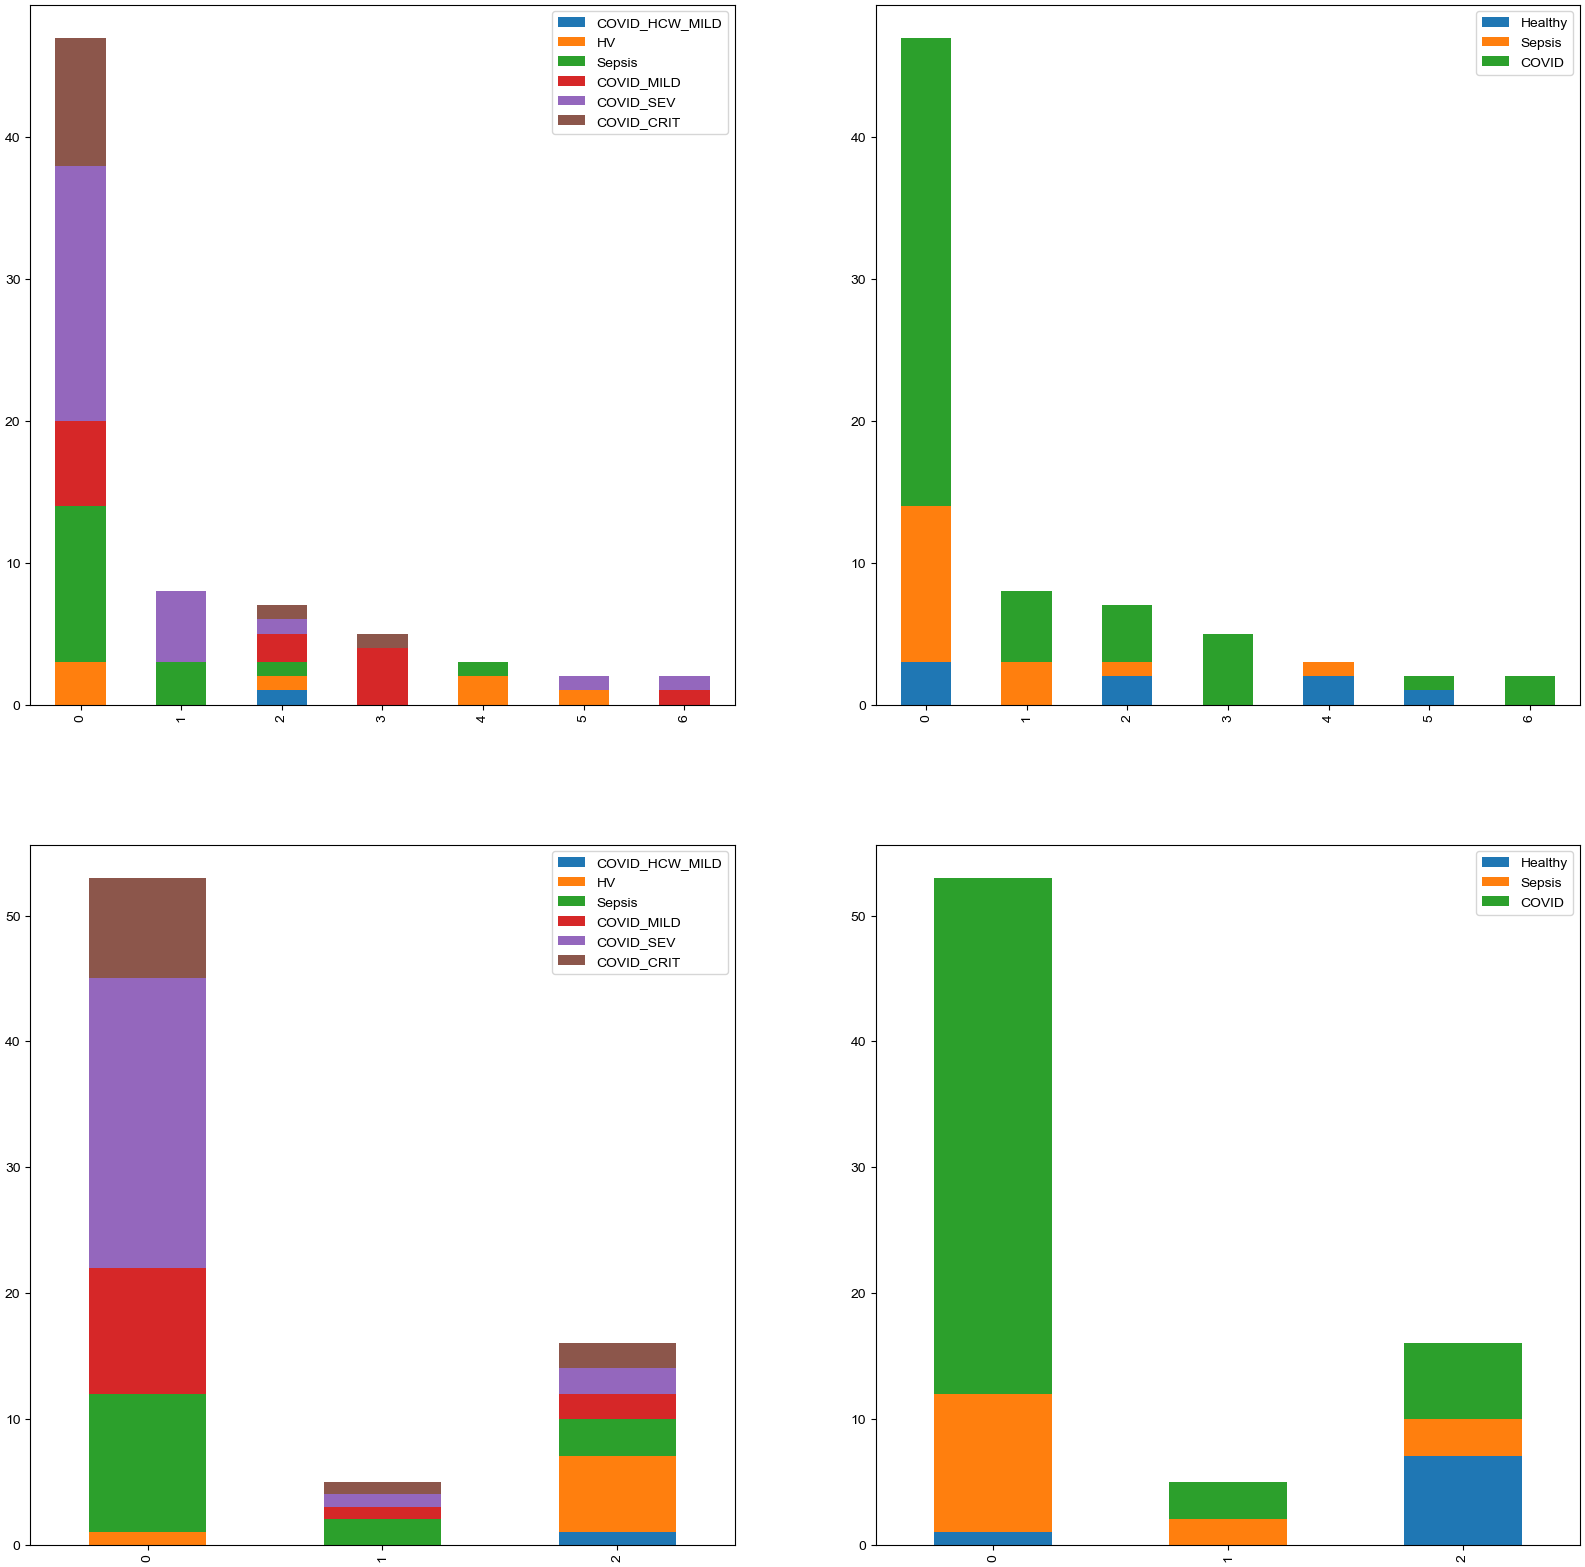

In [ ]:
data = {"g1": g1.X, "g2": g2.X, "g3": g3.X, "g4": g4, "g5": g5.X, "g6": g6}
hp_fused, score_fused, fused_snf = snf_optimize(data = data, num_iter=100)

spectral_and_leiden_clustering(fused_snf, K["vis"], 1)

### SNF - Weighted AVG - SNF

In [ ]:
data_citeRNA = {id: g.X for id, g in citeRNA_g_with_74.items()}
data_bulkRNA = {id: g.X for id, g in bulkRNA_g_with_74.items()}
data_adt = {id: g.X for id, g in adt_g_with_74.items()}
data_luminex = {id: g.X for id, g in luminex_g_with_74.items()}
data_cytof = {id: g.X for id, g in cytof_g_with_74.items()}
data_facs = {id: g.X for id, g in facs_g_with_74.items()}

hp1, s1, g1 = snf_optimize(data=data_citeRNA, num_iter=100)
hp2, s2, g2 = snf_optimize(data=data_bulkRNA, num_iter=100)
hp3, s3, g3 = snf_optimize(data=data_adt, num_iter=100)
hp4, s4, g4 = snf_optimize(data=data_luminex, num_iter=100)
hp5, s5, g5 = snf_optimize(data=data_cytof, num_iter=100)
hp6, s6, g6 = snf_optimize(data=data_facs, num_iter=100)

/var/folders/d6/19fjtfkn2rb94y09ln9bk6m00000gn/T/ipykernel_76409/2852927447.py:22: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  fused_network_ad = ad.AnnData(fused_network)
/var/folders/d6/19fjtfkn2rb94y09ln9bk6m00000gn/T/ipykernel_76409/2852927447.py:22: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  fused_network_ad = ad.AnnData(fused_network)
/var/folders/d6/19fjtfkn2rb94y09ln9bk6m00000gn/T/ipykernel_76409/2852927447.py:22: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly

In [ ]:
g1.X  = (g1.X - g1.X.min()) / (g1.X.max() - g1.X.min())
g2.X = (g2.X - g2.X.min()) / (g2.X.max() - g2.X.min())
g3.X = (g3.X - g3.X.min()) / (g3.X.max() - g3.X.min())
g4.X = (g4.X - g4.X.min()) / (g4.X.max() - g4.X.min())
g5.X = (g5.X - g5.X.min()) / (g5.X.max() - g5.X.min())
g6.X = (g6.X - g6.X.min()) / (g6.X.max() - g6.X.min())

In [ ]:
data_RNA = {"g1":g1.X, "g2": g2.X}
data_Protein = {"g3": g3.X, "g5": g5.X, "g6": g6.X}

In [ ]:
s, w, fused_weighted_avg_RNA = weighted_avg_optimize(100000, data_RNA)
s, w, fused_weighted_avg_protein = weighted_avg_optimize(100000, data_Protein)

In [ ]:
fused_weighted_avg_RNA.X = (fused_weighted_avg_RNA.X - fused_weighted_avg_RNA.X.min()) / (fused_weighted_avg_RNA.X.max() - fused_weighted_avg_RNA.X.min())
fused_weighted_avg_protein.X = (fused_weighted_avg_protein.X - fused_weighted_avg_protein.X.min()) / (fused_weighted_avg_protein.X.max() - fused_weighted_avg_protein.X.min())

data = {"g4": g4.X, "rna": fused_weighted_avg_RNA.X, "protein": fused_weighted_avg_protein.X}
s, w, fused = snf_optimize(data = data, num_iter=100)

/var/folders/d6/19fjtfkn2rb94y09ln9bk6m00000gn/T/ipykernel_76409/1408936411.py:22: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  fused_network_ad = ad.AnnData(fused_network)
/var/folders/d6/19fjtfkn2rb94y09ln9bk6m00000gn/T/ipykernel_76409/1408936411.py:22: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  fused_network_ad = ad.AnnData(fused_network)
/var/folders/d6/19fjtfkn2rb94y09ln9bk6m00000gn/T/ipykernel_76409/1408936411.py:22: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly

/opt/anaconda3/envs/thesis/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:248: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)


interesting patients:  S00005    COVID_SEV   spectral:  0 ,  leiden:  0
interesting patients:  S00020    COVID_CRIT   spectral:  0 ,  leiden:  0
interesting patients:  S00027    COVID_CRIT   spectral:  0 ,  leiden:  0
interesting patients:  S00033    COVID_SEV   spectral:  0 ,  leiden:  0
interesting patients:  S00040    COVID_CRIT   spectral:  0 ,  leiden:  0
interesting patients:  S00065    COVID_CRIT   spectral:  0 ,  leiden:  0
interesting patients:  S00068    COVID_CRIT   spectral:  0 ,  leiden:  2
interesting patients:  S00095    COVID_CRIT   spectral:  0 ,  leiden:  0
interesting patients:  S00119    COVID_SEV   spectral:  0 ,  leiden:  0
patients grouped with healthy leiden  ['G05073', 'H00053', 'H00054', 'H00058', 'H00064', 'H00070', 'H00072', 'H00085', 'N00007', 'N00012', 'N00017', 'N00028', 'N00029', 'N00032', 'N00033', 'N00037', 'N00038', 'N00039', 'N00047', 'S00002', 'S00003', 'S00005', 'S00006', 'S00007', 'S00016', 'S00020', 'S00027', 'S00033', 'S00034', 'S00037', 'S00039

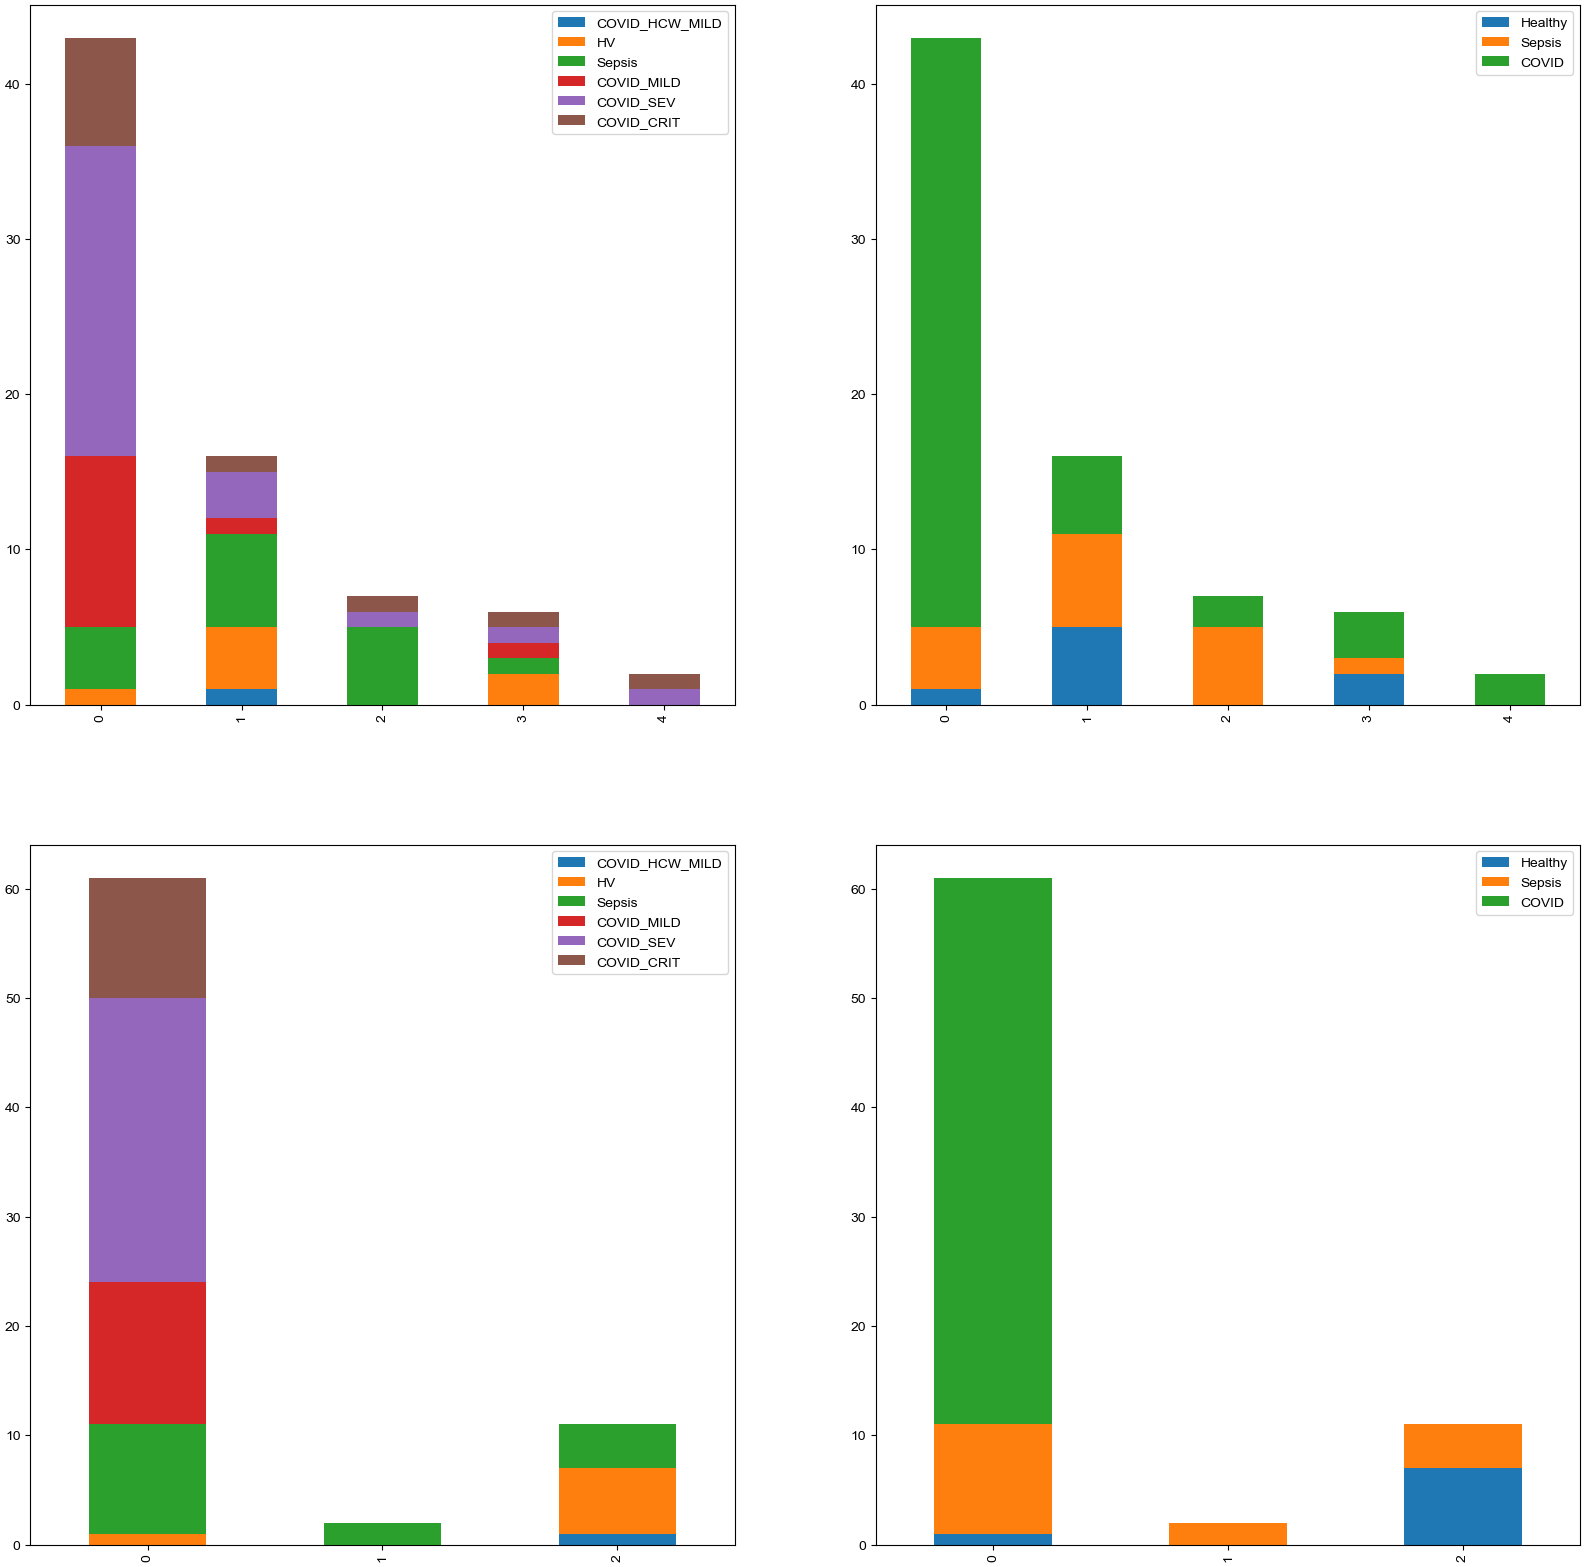

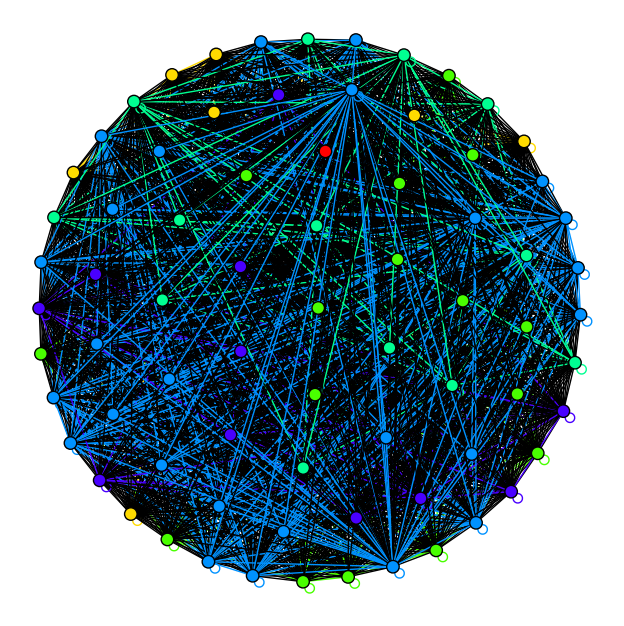

In [ ]:
spectral_and_leiden_clustering(fused,7 , 1)
visualized_d(fused)

### SNF -  SNF - SNF


In [ ]:
data_citeRNA = {id: g.X for id, g in citeRNA_g_with_74.items()}
data_bulkRNA = {id: g.X for id, g in bulkRNA_g_with_74.items()}
data_adt = {id: g.X for id, g in adt_g_with_74.items()}
data_luminex = {id: g.X for id, g in luminex_g_with_74.items()}
data_cytof = {id: g.X for id, g in cytof_g_with_74.items()}
data_facs = {id: g.X for id, g in facs_g_with_74.items()}

hp1, s1, g1 = snf_optimize(data=data_citeRNA, num_iter=100)
hp2, s2, g2 = snf_optimize(data=data_bulkRNA, num_iter=100)
hp3, s3, g3 = snf_optimize(data=data_adt, num_iter=100)
hp4, s4, g4 = snf_optimize(data=data_luminex, num_iter=100)
hp5, s5, g5 = snf_optimize(data=data_cytof, num_iter=100)
hp6, s6, g6 = snf_optimize(data=data_facs, num_iter=100)

/var/folders/d6/19fjtfkn2rb94y09ln9bk6m00000gn/T/ipykernel_76409/1408936411.py:22: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  fused_network_ad = ad.AnnData(fused_network)
/var/folders/d6/19fjtfkn2rb94y09ln9bk6m00000gn/T/ipykernel_76409/1408936411.py:22: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  fused_network_ad = ad.AnnData(fused_network)
/var/folders/d6/19fjtfkn2rb94y09ln9bk6m00000gn/T/ipykernel_76409/1408936411.py:22: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly

In [ ]:
g1.X  = (g1.X - g1.X.min()) / (g1.X.max() - g1.X.min())
g2.X = (g2.X - g2.X.min()) / (g2.X.max() - g2.X.min())
g3.X = (g3.X - g3.X.min()) / (g3.X.max() - g3.X.min())
g4.X = (g4.X - g4.X.min()) / (g4.X.max() - g4.X.min())
g5.X = (g5.X - g5.X.min()) / (g5.X.max() - g5.X.min())
g6.X = (g6.X - g6.X.min()) / (g6.X.max() - g6.X.min())

In [ ]:
data_RNA = {"g1":g1.X, "g2": g2.X}
data_Protein = {"g3": g3.X, "g5": g5.X, "g6": g6.X}

s, w, fused_snf_RNA = snf_optimize(data=data_RNA, num_iter=100)
s, w, fused_snf_protein = snf_optimize(data=data_Protein, num_iter=100)

/var/folders/d6/19fjtfkn2rb94y09ln9bk6m00000gn/T/ipykernel_76409/1408936411.py:22: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  fused_network_ad = ad.AnnData(fused_network)
/var/folders/d6/19fjtfkn2rb94y09ln9bk6m00000gn/T/ipykernel_76409/1408936411.py:22: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  fused_network_ad = ad.AnnData(fused_network)
/var/folders/d6/19fjtfkn2rb94y09ln9bk6m00000gn/T/ipykernel_76409/1408936411.py:22: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly

In [ ]:
fused_snf_RNA.X = (fused_snf_RNA.X - fused_snf_RNA.X.min()) / (fused_snf_RNA.X.max() - fused_snf_RNA.X.min())
fused_snf_protein.X = (fused_snf_protein.X - fused_snf_protein.X.min()) / (fused_snf_protein.X.max() - fused_snf_protein.X.min())

data = {"g4": g4.X, "fused_snf_RNA": fused_snf_RNA.X, "fused_snf_protein": fused_snf_protein.X}

s, w, fused_snf = snf_optimize(data=data, num_iter=100)

/var/folders/d6/19fjtfkn2rb94y09ln9bk6m00000gn/T/ipykernel_76409/1408936411.py:22: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  fused_network_ad = ad.AnnData(fused_network)
/var/folders/d6/19fjtfkn2rb94y09ln9bk6m00000gn/T/ipykernel_76409/1408936411.py:22: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  fused_network_ad = ad.AnnData(fused_network)
/var/folders/d6/19fjtfkn2rb94y09ln9bk6m00000gn/T/ipykernel_76409/1408936411.py:22: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly

/opt/anaconda3/envs/thesis/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:248: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)


interesting patients:  S00005    COVID_SEV   spectral:  1 ,  leiden:  6
interesting patients:  S00020    COVID_CRIT   spectral:  1 ,  leiden:  2
interesting patients:  S00027    COVID_CRIT   spectral:  1 ,  leiden:  0
interesting patients:  S00033    COVID_SEV   spectral:  1 ,  leiden:  0
interesting patients:  S00040    COVID_CRIT   spectral:  1 ,  leiden:  0
interesting patients:  S00065    COVID_CRIT   spectral:  1 ,  leiden:  2
interesting patients:  S00068    COVID_CRIT   spectral:  1 ,  leiden:  4
interesting patients:  S00095    COVID_CRIT   spectral:  1 ,  leiden:  3
interesting patients:  S00119    COVID_SEV   spectral:  1 ,  leiden:  1
patients grouped with healthy leiden  ['H00053', 'H00054', 'H00058', 'H00064', 'H00070', 'H00072', 'H00085', 'N00006', 'N00007', 'N00029', 'N00033', 'S00039', 'S00054', 'S00106', 'S00114', 'S00119']
patients grouped with healthy spectral  [] 



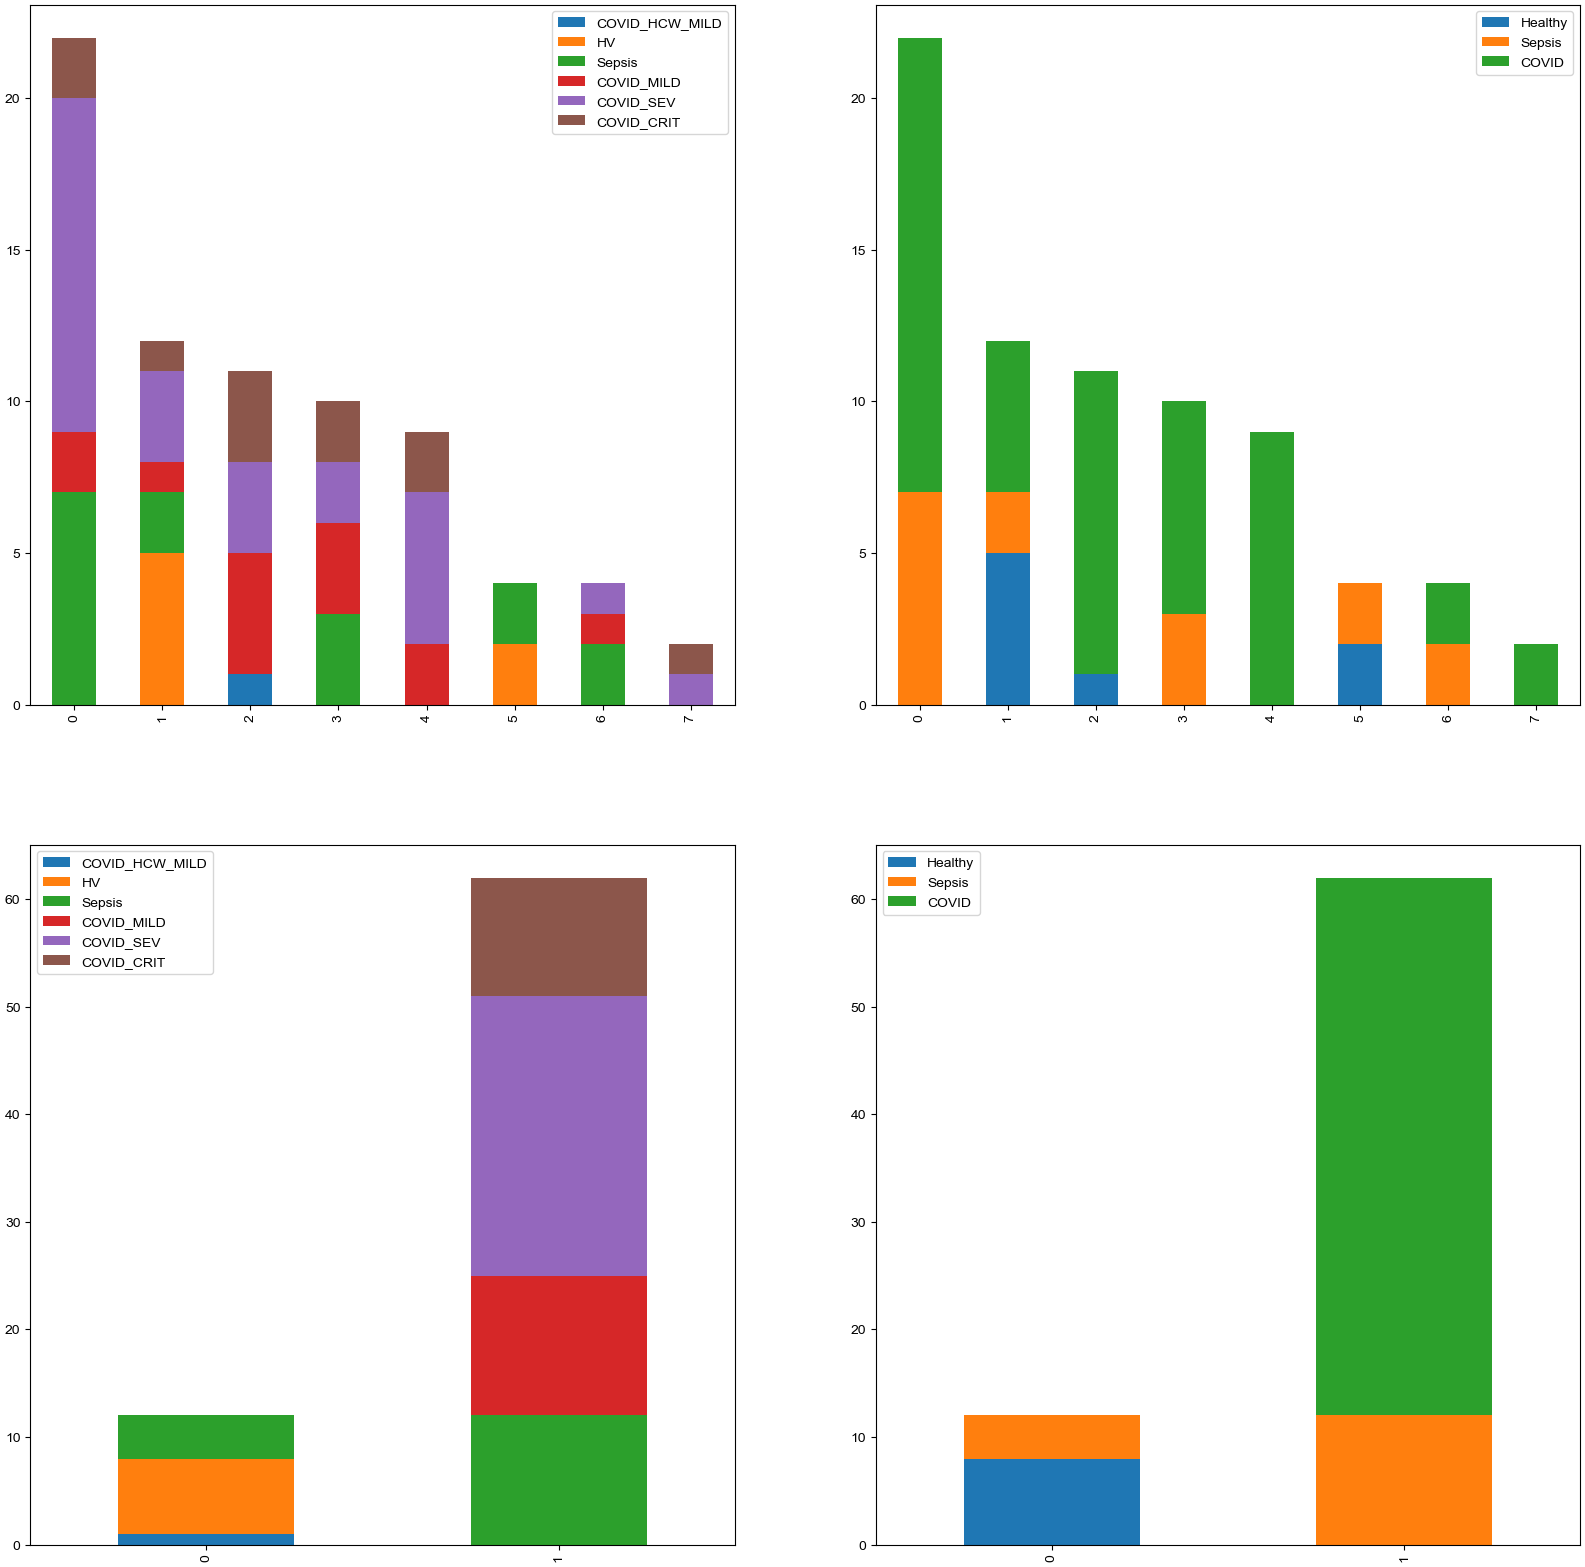

In [ ]:
spectral_and_leiden_clustering(fused_snf, 7, 1)

## Network Scores

In [ ]:
forb_norm = []
for i, g1 in enumerate(graphs_with_74_nodes):
    forb_norm_with_g1 = []
    g1 = sparse.csr_matrix.todense(g1.obsp["connectivities"])
    for j, g2 in enumerate(graphs_with_74_nodes):
        g2 = sparse.csr_matrix.todense(g2.obsp["connectivities"])
        diff = g1 - g2
        norm = np.linalg.norm(diff)
        #forb_norm_with_g1.append(1/(1+norm))
        forb_norm_with_g1.append(norm)
    forb_norm.append(forb_norm_with_g1)

forb_norm = np.array(forb_norm)
forb_norm_df = pd.DataFrame(forb_norm)


In [ ]:
corr = []
for i, g1 in enumerate(graphs_with_74_nodes):
    corr_with_g1 = []
    g1 = np.array(sparse.csr_matrix.todense(g1.obsp["connectivities"])).flatten()
    for j, g2 in enumerate(graphs_with_74_nodes):
        g2 = np.array(sparse.csr_matrix.todense(g2.obsp["connectivities"])).flatten()
        pearson = np.corrcoef(g1,g2)[0,1]
        corr_with_g1.append(pearson)
    corr.append(corr_with_g1)

corr = np.array(corr)
corr_df = pd.DataFrame(corr)

In [ ]:
avg_cosine_sim = []
for i, g1 in enumerate(graphs_with_74_nodes):
    avg_cosine_sim_with_g1 = []
    g1 = np.array(sparse.csr_matrix.todense(g1.obsp["connectivities"]))
    for j, g2 in enumerate(graphs_with_74_nodes):
        g2 = np.array(sparse.csr_matrix.todense(g2.obsp["connectivities"]))
        cos_sim = skl.metrics.pairwise.cosine_similarity(g1,g2).mean().mean()
        avg_cosine_sim_with_g1.append(cos_sim)
    avg_cosine_sim.append(avg_cosine_sim_with_g1)

avg_cosine_sim = np.array(avg_cosine_sim)
avg_cosine_sim_df = pd.DataFrame(avg_cosine_sim)

In [ ]:
df_row = pd.DataFrame(number_to_modality.values(), columns=["modality"]).join(pd.DataFrame(number_to_module.values(), columns=["module"]) )
df_column = pd.DataFrame(number_to_modality.values(), columns=["modality"]).join(pd.DataFrame(number_to_module.values(), columns=["module"]) )

In [ ]:
row_colors_dict = {"module":{"none": "grey", "IFN": "blue", "C19": "red", "cycling": "orange", "ZNF": "green", "AP1": "purple" },
                  "modality":{"citeRNA":"skyblue", "bulkRNA": "darkorange" , "cytof": "wheat", "adt": "darkgray", "luminex": "orangered", "facs": "yellowgreen" }  }

row_ha = HeatmapAnnotation(Module=anno_simple(df_row.module,colors=row_colors_dict['module'],rasterized=True),
                           Modality=anno_simple(df_row.modality,colors=row_colors_dict['modality'],rasterized=True),
                           axis=0)
col_ha= HeatmapAnnotation(Module=anno_simple(df_column.module,colors=row_colors_dict['module'],rasterized=True),
                           Modality=anno_simple(df_column.modality,colors=row_colors_dict['modality'],rasterized=True),
                           axis=1)

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..


/opt/anaconda3/envs/thesis/lib/python3.10/site-packages/PyComplexHeatmap/clustermap.py:636: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/opt/anaconda3/envs/thesis/lib/python3.10/site-packages/PyComplexHeatmap/clustermap.py:636: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/opt/anaconda3/envs/thesis/lib/python3.10/site-packages/PyComplexHeatmap/clustermap.py:636: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/opt/anaconda3/envs/thesis/lib/python3.10/site-packages/PyComplexHeatmap/clustermap.py:636: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/opt/anaconda3/envs/thesis/lib/python3.10/site-packages/PyComplexHeatmap/clustermap.py:636: UserWarning: Clustering large matrix with sc

Starting plotting HeatmapAnnotations
Starting plotting HeatmapAnnotations
Plotting legends..


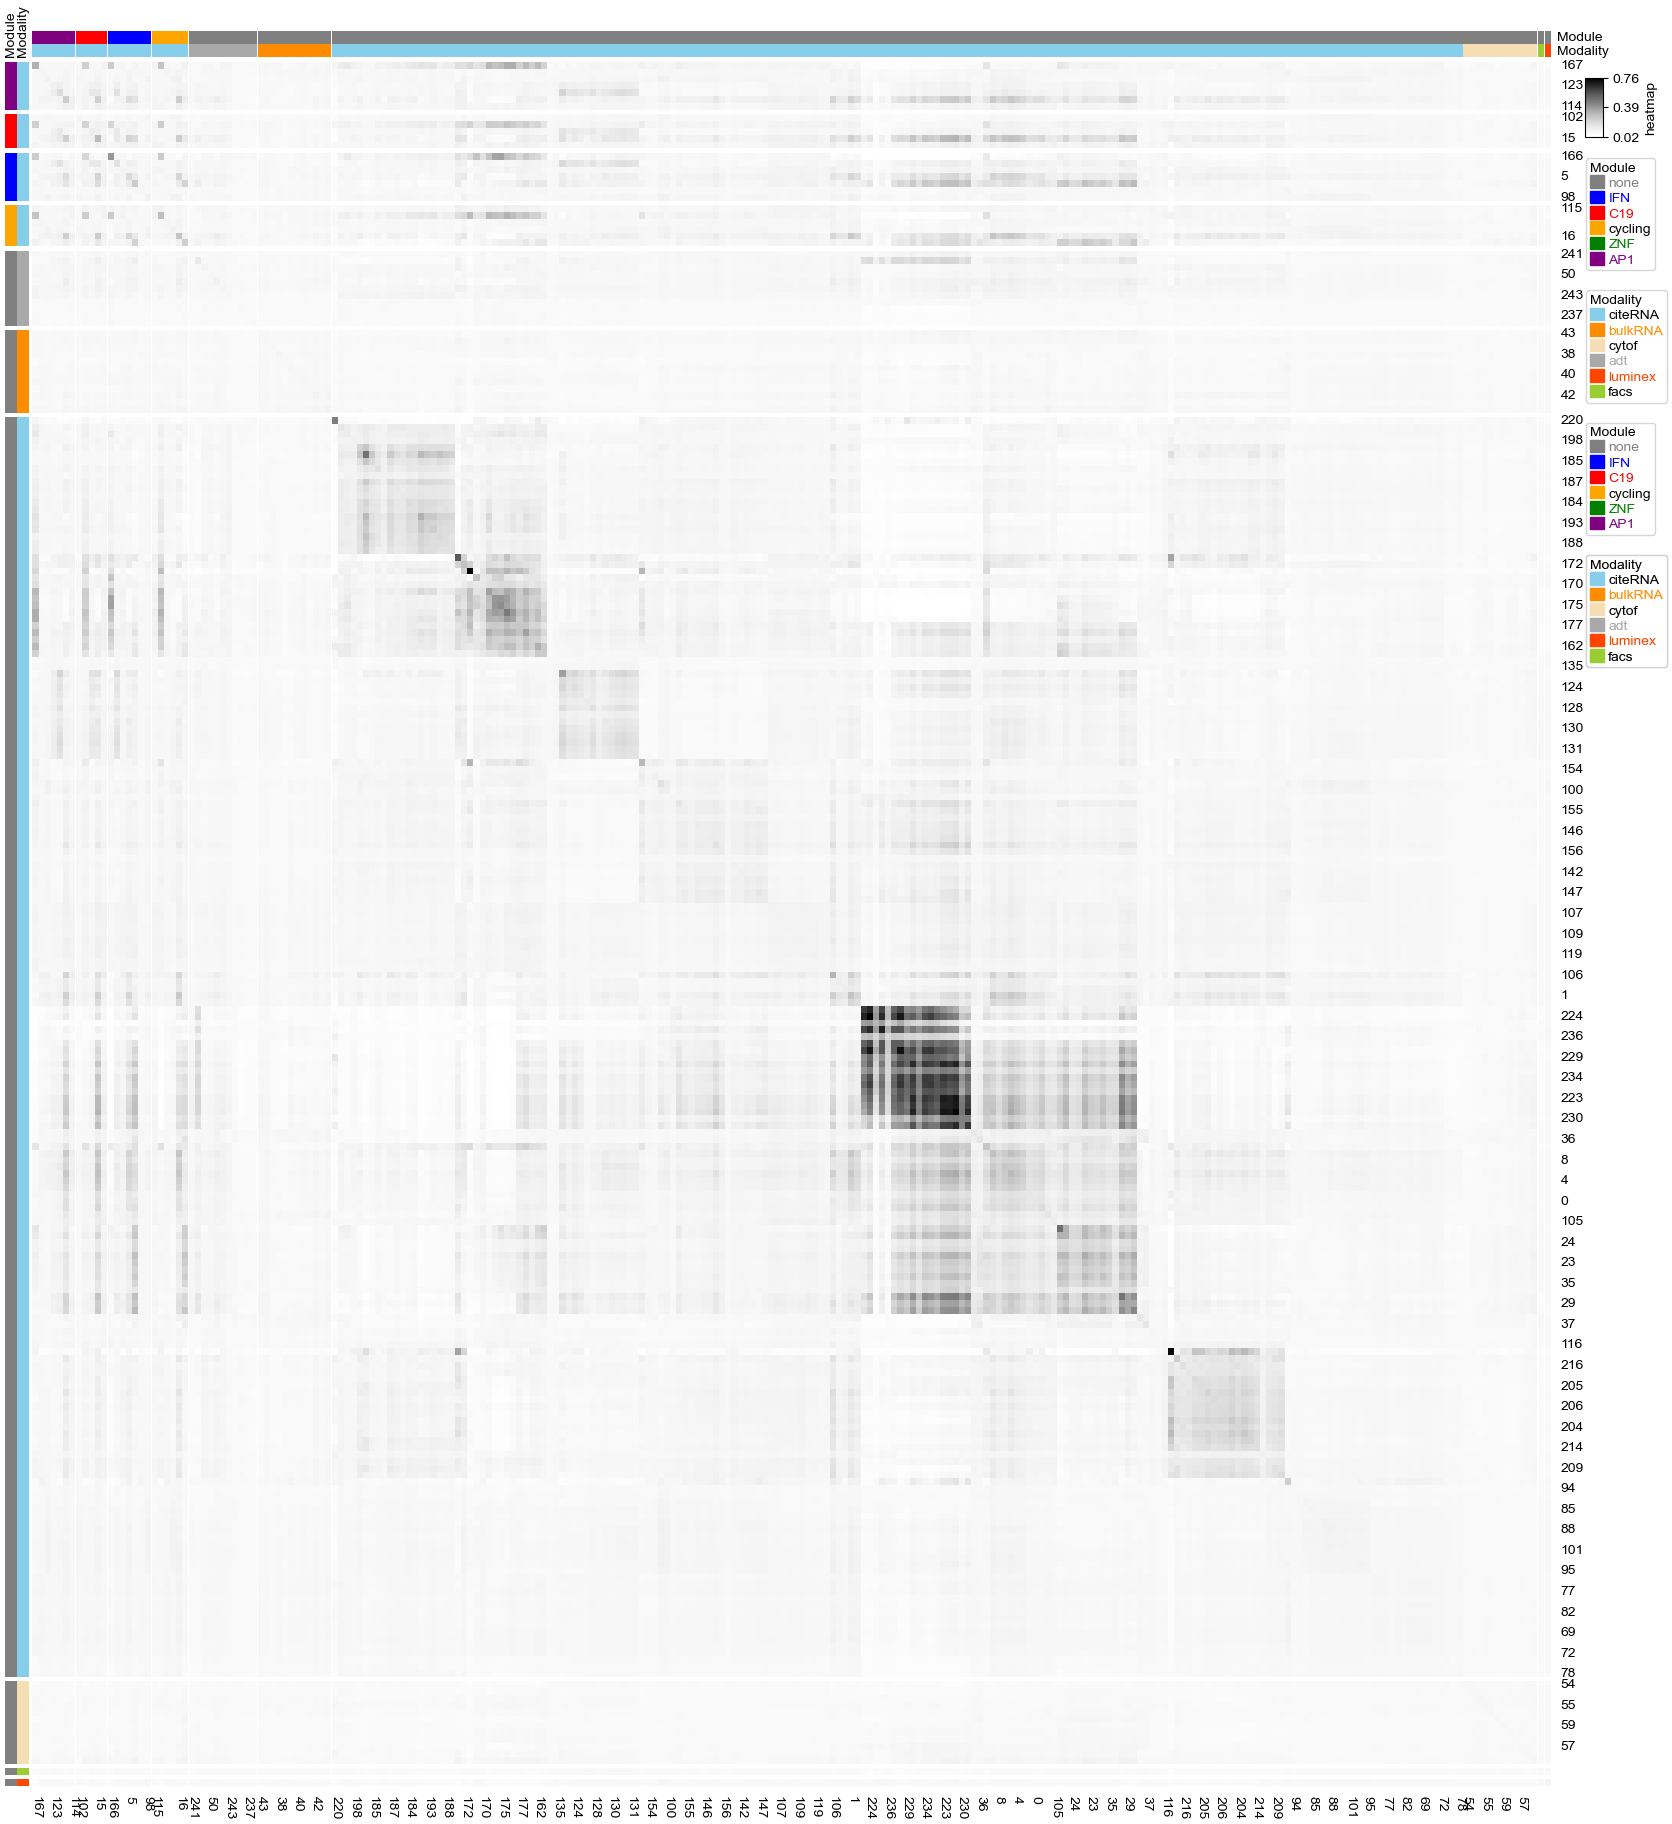

In [ ]:
fig, ax = plt.subplots(figsize=(20,20))

avg_cos_sim_plt = ClusterMapPlotter(data=avg_cosine_sim_df, top_annotation=col_ha, left_annotation=row_ha,
                     show_rownames=True,show_colnames=True,
                     row_dendrogram=False,col_dendrogram=False,
                     row_split=df_row.loc[:, ['module', 'modality']],
                     col_split=df_column.loc[:, ['module', 'modality']],
                     cmap='Greys',
                     rasterized=True,row_split_gap=1,legend=True,legend_anchor='ax_heatmap',legend_vpad=5)


Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..


/opt/anaconda3/envs/thesis/lib/python3.10/site-packages/PyComplexHeatmap/clustermap.py:636: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/opt/anaconda3/envs/thesis/lib/python3.10/site-packages/PyComplexHeatmap/clustermap.py:636: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/opt/anaconda3/envs/thesis/lib/python3.10/site-packages/PyComplexHeatmap/clustermap.py:636: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/opt/anaconda3/envs/thesis/lib/python3.10/site-packages/PyComplexHeatmap/clustermap.py:636: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/opt/anaconda3/envs/thesis/lib/python3.10/site-packages/PyComplexHeatmap/clustermap.py:636: UserWarning: Clustering large matrix with sc

Starting plotting HeatmapAnnotations
Starting plotting HeatmapAnnotations
Plotting legends..


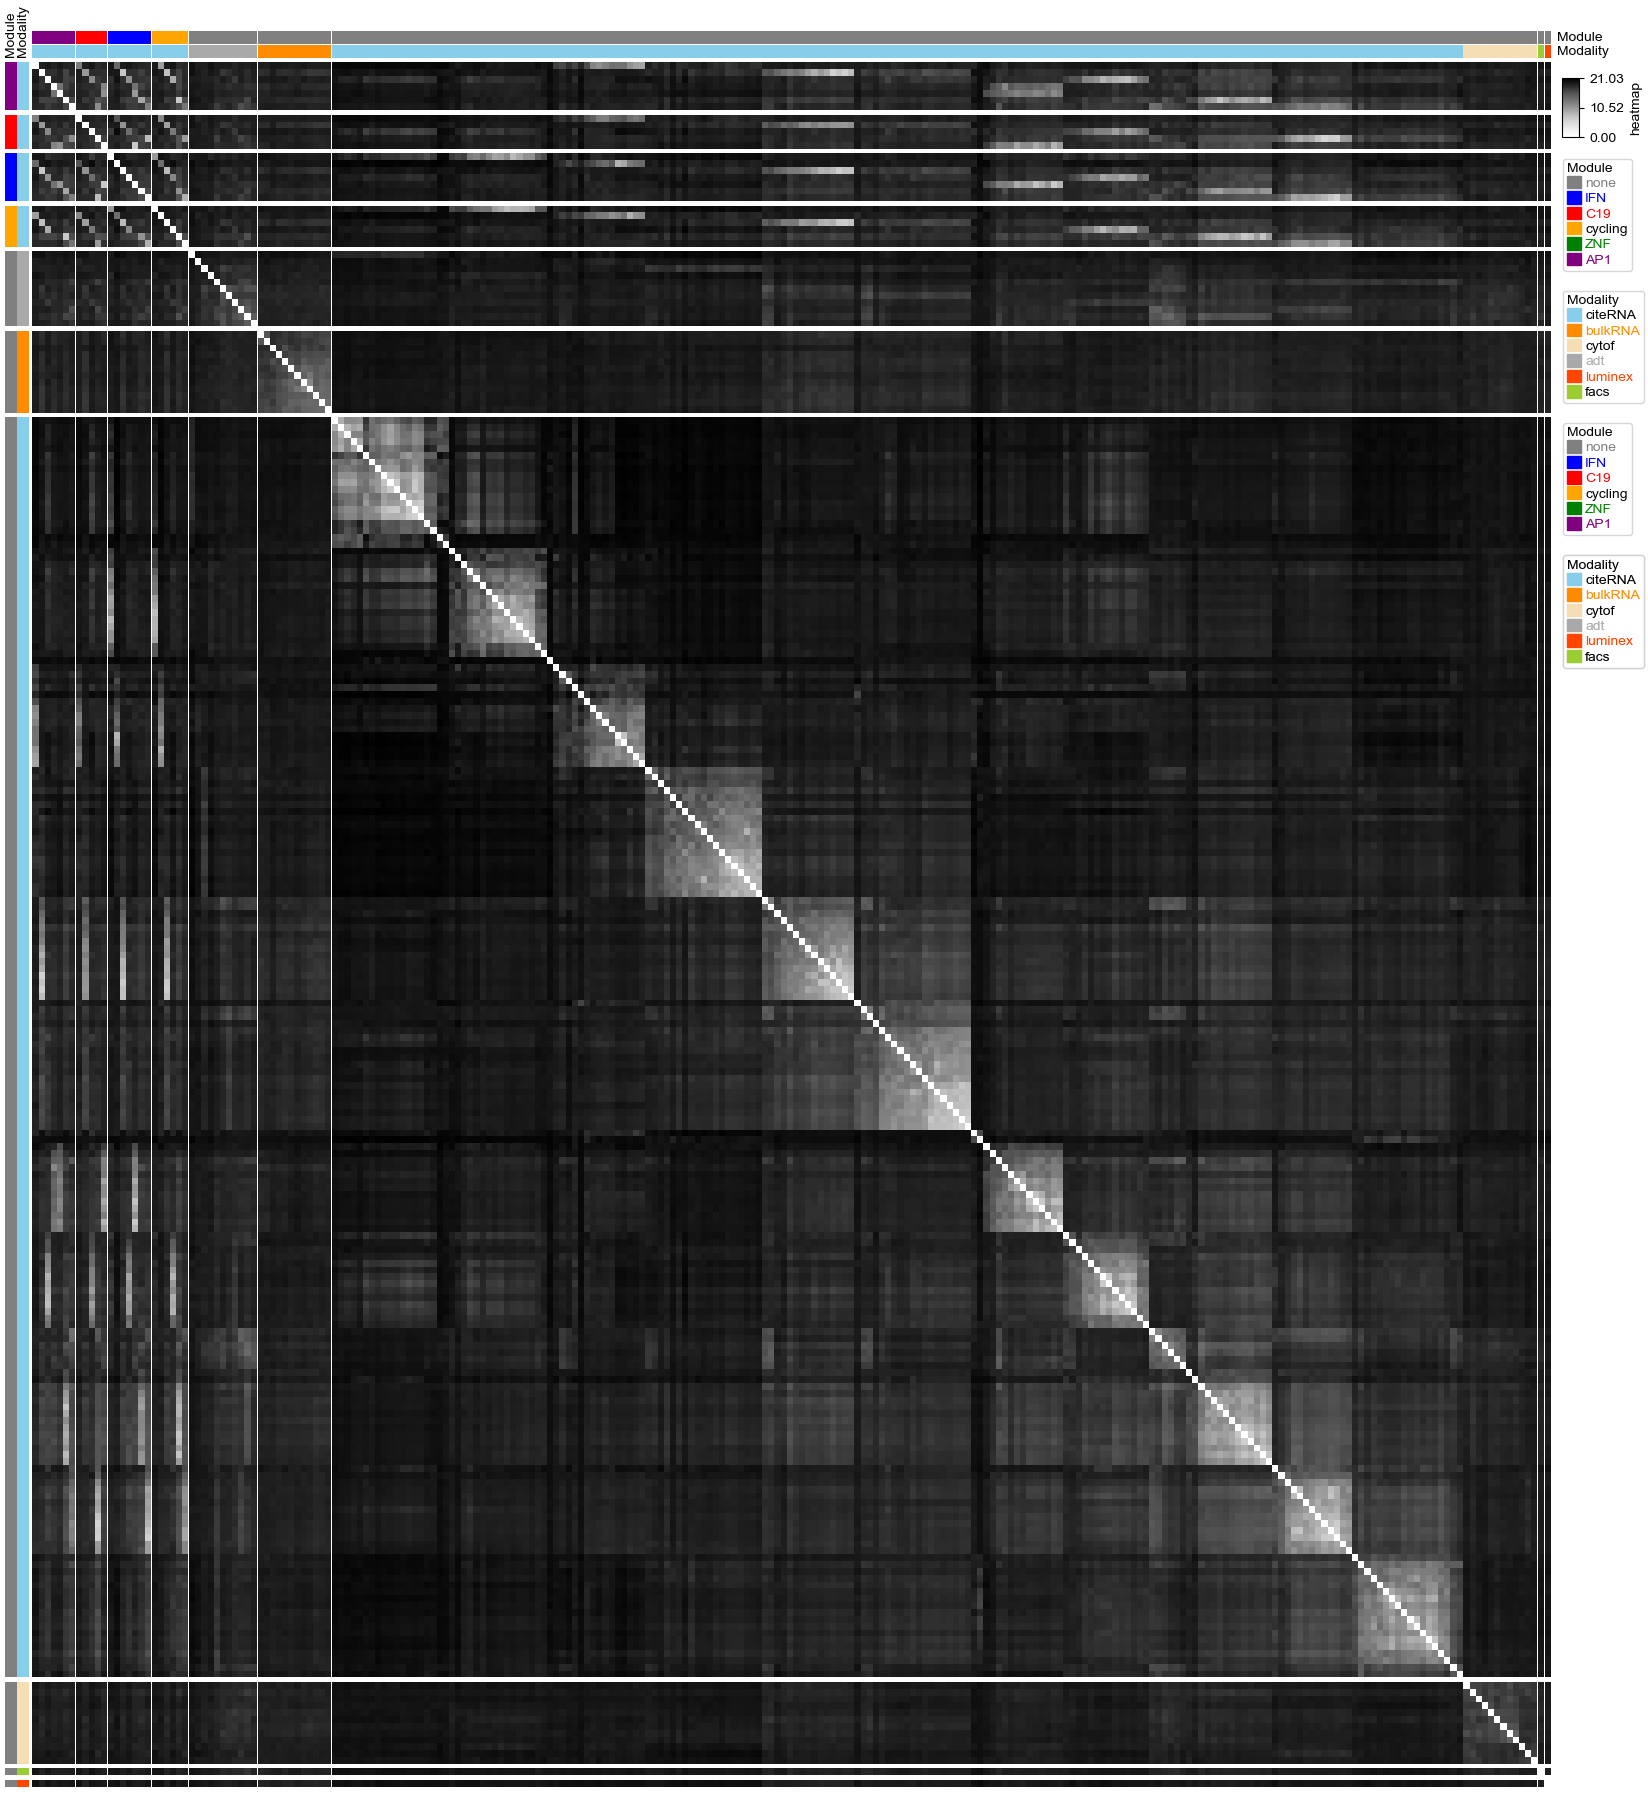

In [ ]:
fig, ax = plt.subplots(figsize=(20,20))
forb_norm_plt = ClusterMapPlotter(data=forb_norm_df, top_annotation=col_ha, left_annotation=row_ha,
                     show_rownames=False,show_colnames=False,
                     row_dendrogram=False,col_dendrogram=False,
                     row_split=df_row.loc[:, ['module', 'modality']],
                     col_split=df_column.loc[:, ['module', 'modality']],
                     cmap='Greys',
                     rasterized=True,row_split_gap=1,legend=True,legend_anchor='ax_heatmap',legend_vpad=5)

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..


/opt/anaconda3/envs/thesis/lib/python3.10/site-packages/PyComplexHeatmap/clustermap.py:636: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/opt/anaconda3/envs/thesis/lib/python3.10/site-packages/PyComplexHeatmap/clustermap.py:636: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/opt/anaconda3/envs/thesis/lib/python3.10/site-packages/PyComplexHeatmap/clustermap.py:636: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/opt/anaconda3/envs/thesis/lib/python3.10/site-packages/PyComplexHeatmap/clustermap.py:636: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/opt/anaconda3/envs/thesis/lib/python3.10/site-packages/PyComplexHeatmap/clustermap.py:636: UserWarning: Clustering large matrix with sc

Starting plotting HeatmapAnnotations
Starting plotting HeatmapAnnotations
Plotting legends..


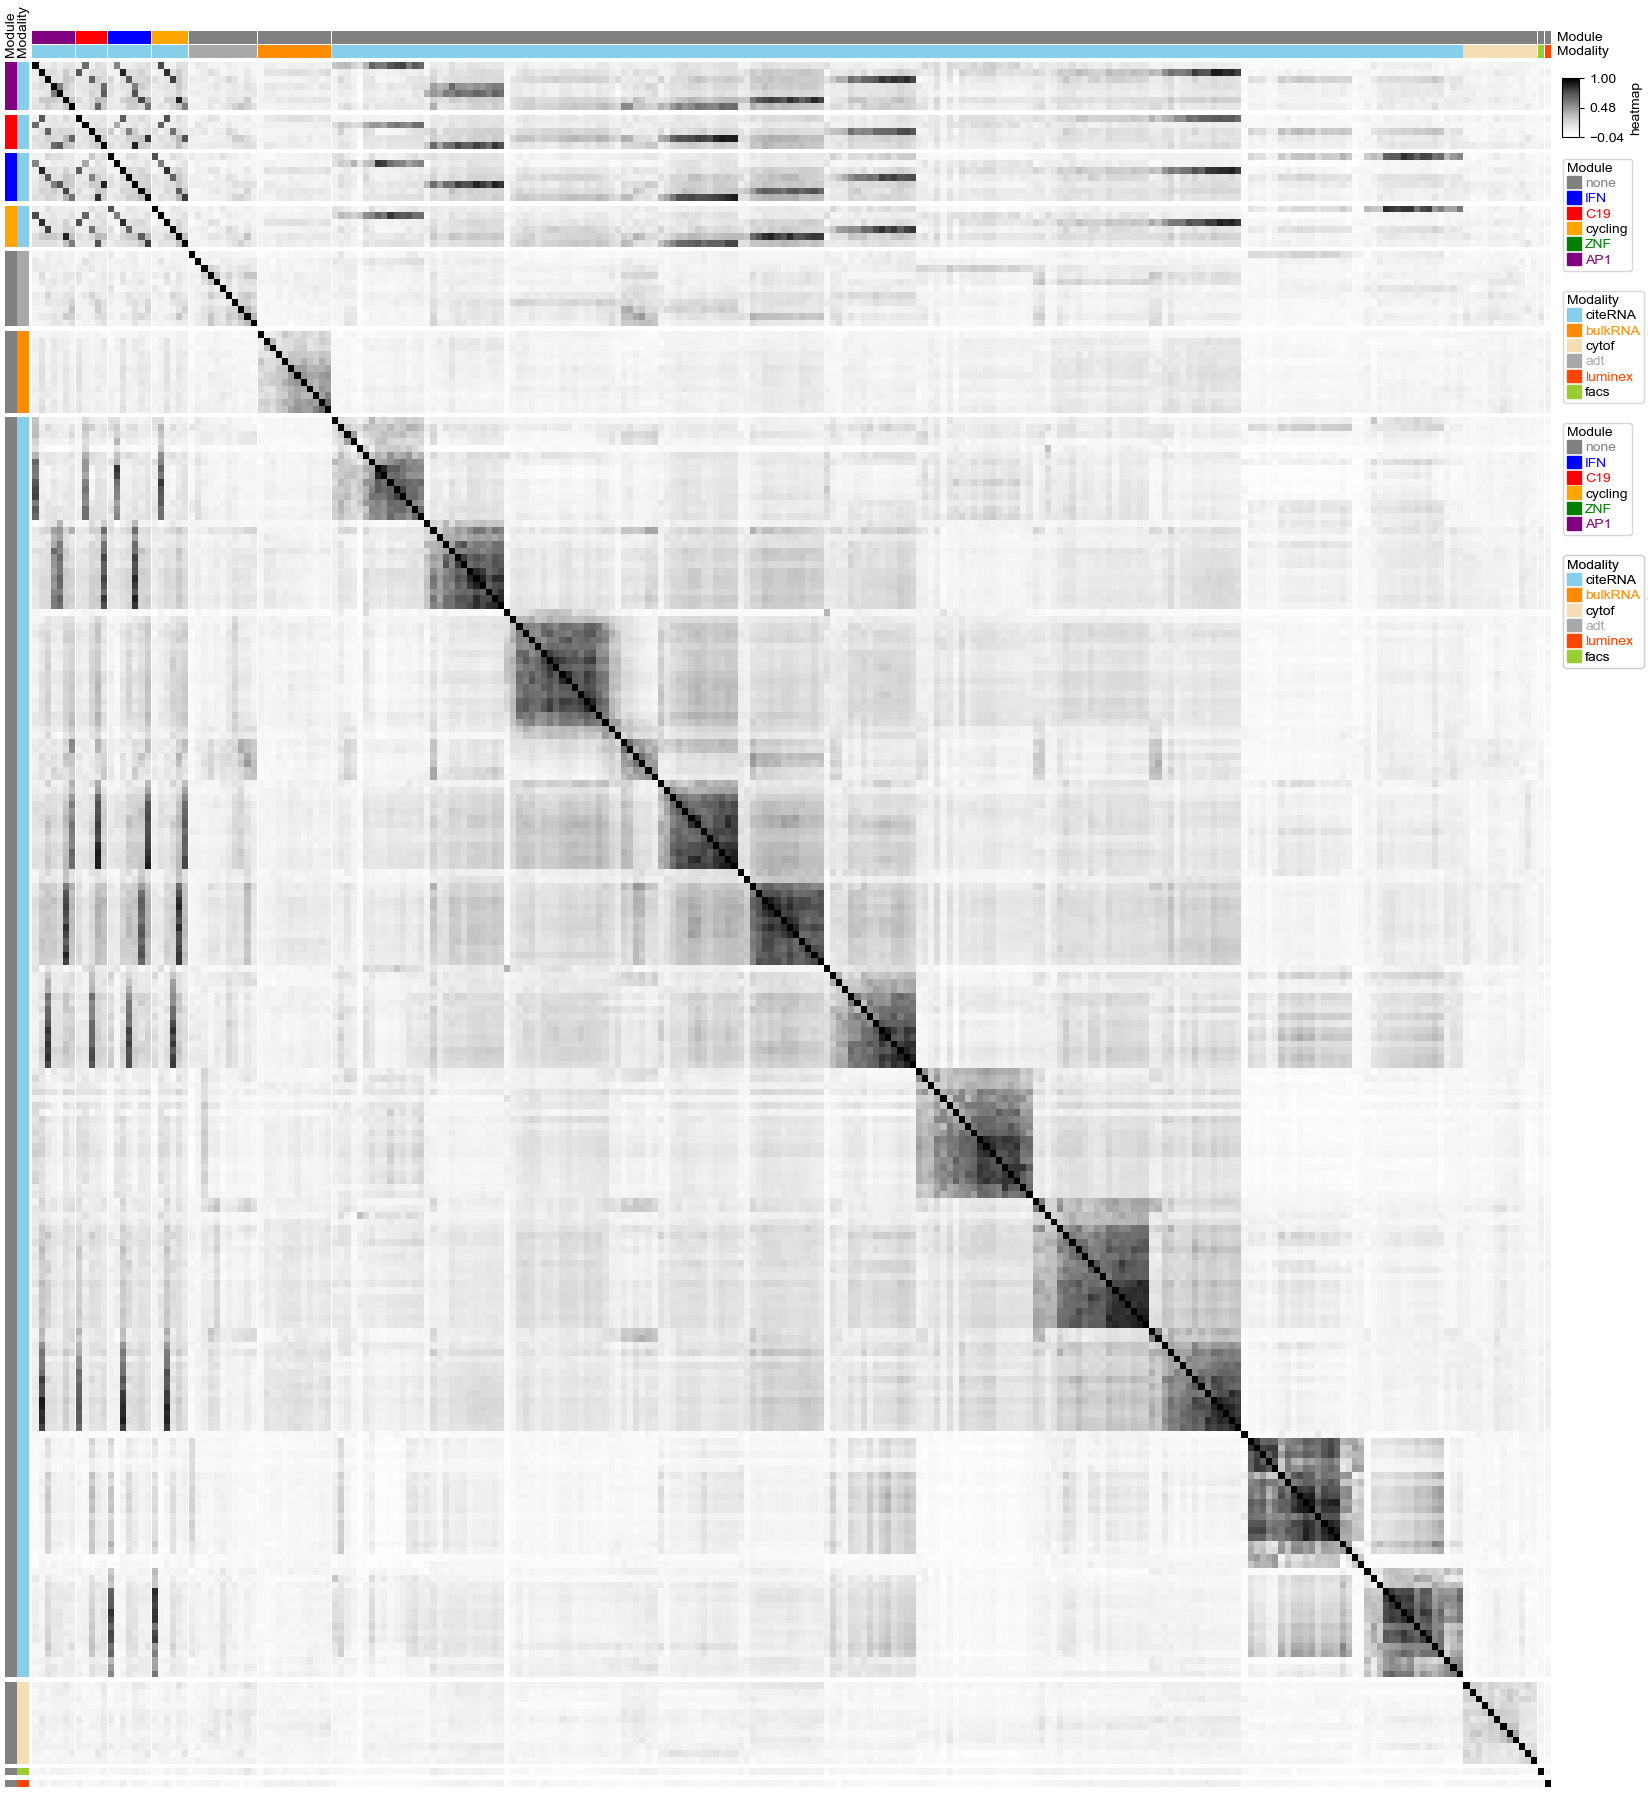

In [ ]:
fig, ax = plt.subplots(figsize=(20,20))
corr_plt = ClusterMapPlotter(data=corr_df, top_annotation=col_ha, left_annotation=row_ha,
                     show_rownames=False,show_colnames=False,
                     row_dendrogram=False,col_dendrogram=False,
                     row_split=df_row.loc[:, ['module', 'modality']],
                     col_split=df_column.loc[:, ['module', 'modality']],
                     cmap='Greys',
                     rasterized=True,row_split_gap=1,legend=True,legend_anchor='ax_heatmap',legend_vpad=5)

Text(0.5, 1.0, 'avg cosine similarity')

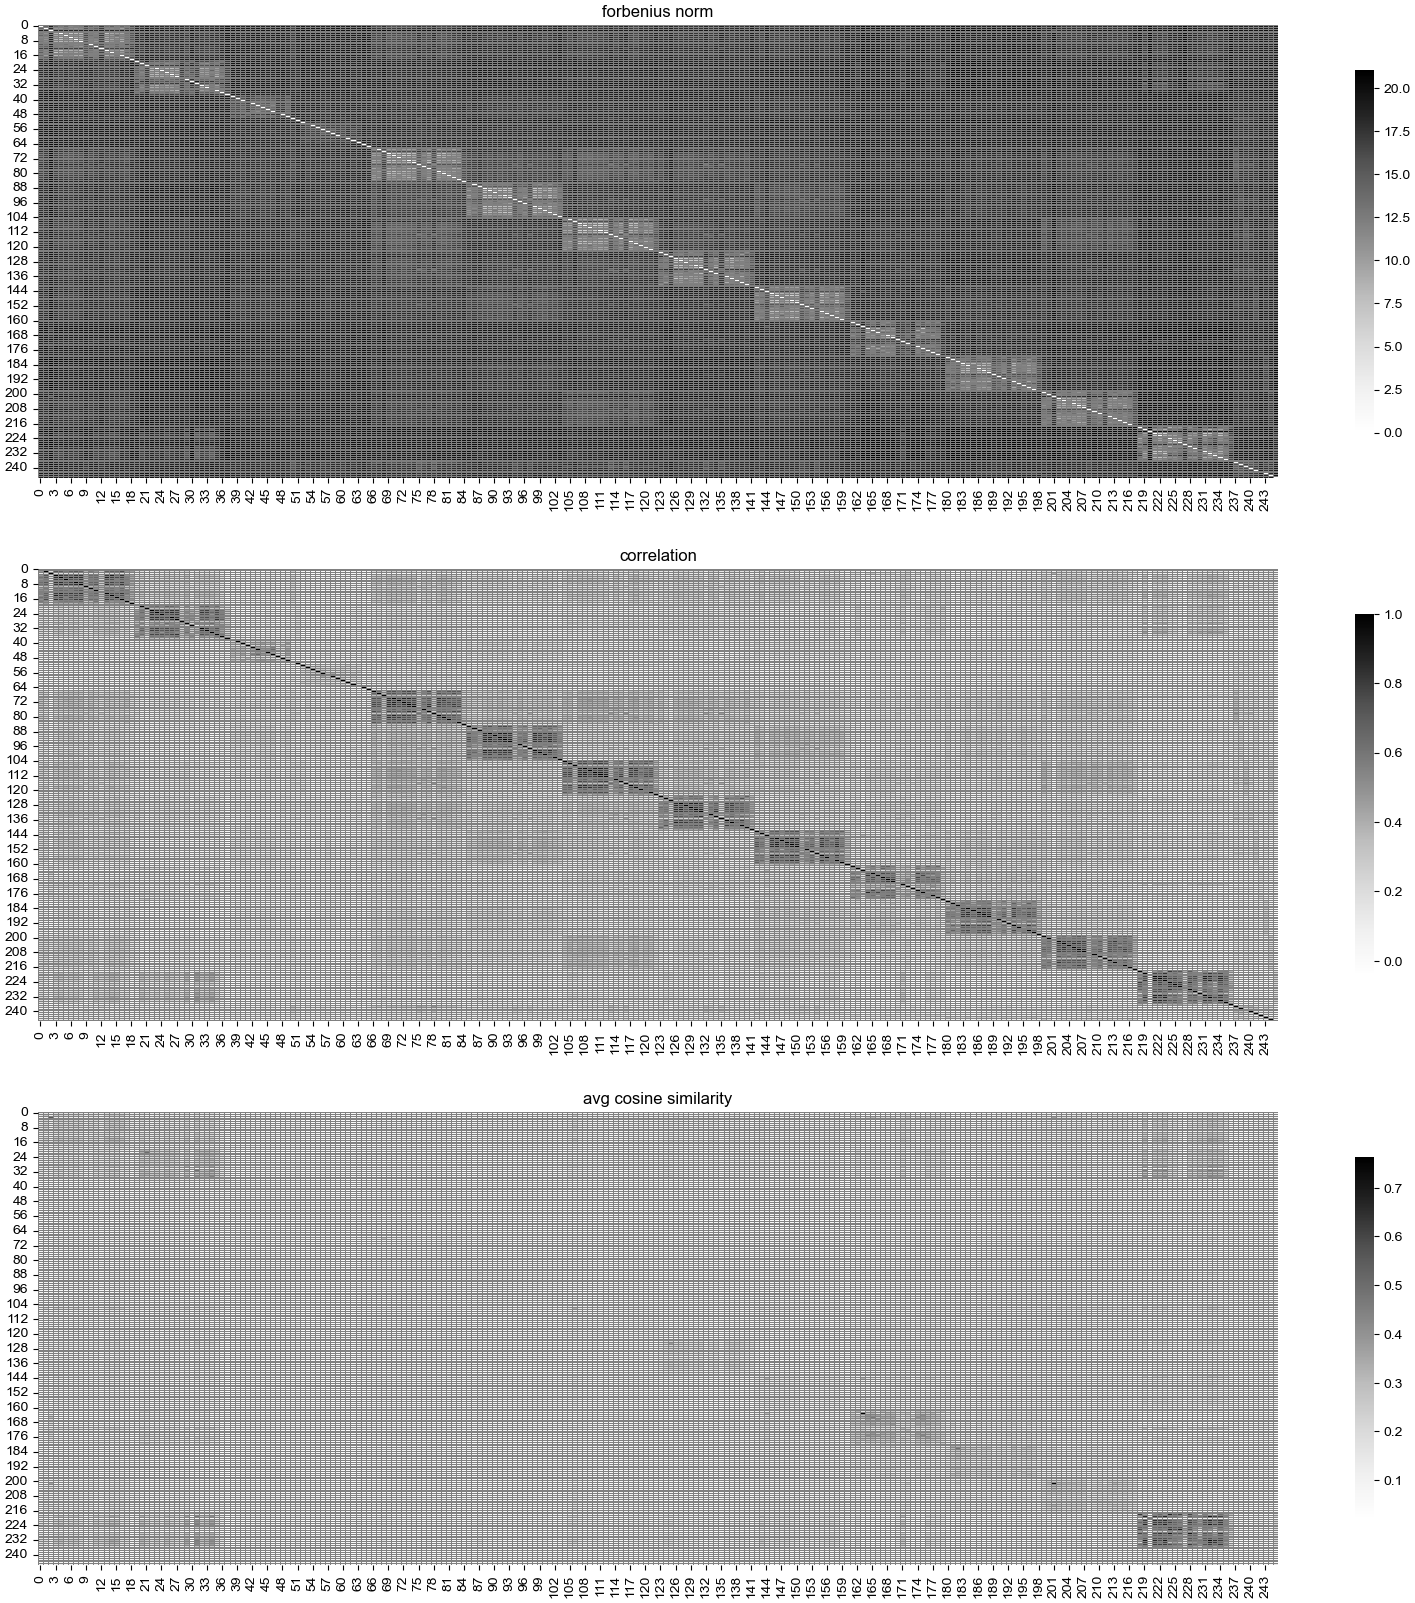

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(20,20))
sb.heatmap(forb_norm, ax = ax[0], cmap = "Greys", robust = False, linewidth=.5, linecolor = "grey", cbar_kws={"shrink": 0.8})
ax[0].set_title("forbenius norm")
sb.heatmap(corr, ax = ax[1], cmap = "Greys", robust = False, linewidth=.5, linecolor = "grey", cbar_kws={"shrink": 0.8})
ax[1].set_title("correlation")
sb.heatmap(avg_cosine_sim, ax = ax[2], cmap = "Greys", robust = False, linewidth=.5, linecolor = "grey", cbar_kws={"shrink": 0.8})
ax[2].set_title("avg cosine similarity")